## HARPS-N Solar Data Neural Networks Code (TensorFlow 2.x Update)

Original by Zoe L. de Beurs 
Updated to use Tensorflow v2 by Son Do

See [de Beurs, Zoe L., Vanderburg, A., Shallue, C.J., et al. (2022)](https://iopscience.iop.org/article/10.3847/1538-3881/ac738e/pdf) for more details 

*This notebook has been updated to remove deprecated `tf.estimator` calls and use a modern TensorFlow 2.x custom training loop.*

In [ ]:
# Install tensorflow_addons if needed, as it's used for the optimizer
#! pip install tensorflow_addons
! pip install ipywidgets

In [1]:
# import needed packages
import os.path
import numpy as np
import tensorflow as tf
#import tensorflow_addons as tfa
from types import SimpleNamespace # Used to replace configdict
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

import pandas as pd
from sklearn.linear_model import LinearRegression
from astropy.stats import median_absolute_deviation
import numpy as np
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from sklearn.linear_model import Ridge

2.20.0


In [ ]:
#! git clone https://github.com/zdebeurs/rv_net

In [2]:
# rv_net imports.
import sys
sys.path.append("rv_net/")

# Note: We will use the internal definitions for load_dataset_ridge and ridge_regress_harps
# The estimator-related imports are no longer needed.
# from ops import training
# from tf_util import config_util
# from tf_util import configdict # Replaced with SimpleNamespace
# from tf_util import estimator_runner
# from rv_net import data_HARPS_N
# from rv_net import  data, rv_model, estimator_util, load_dataset_ridge, ridge_regress_harps

In [3]:
# @title Residual plotting code
import matplotlib as mpl
def residual_plot(rv_list, x_axis, ccfs_of_interest, num_ref_ccf, plot_title):
    # create color scheme
    min_rv = np.min(rv_list)
    max_rv = np.max(rv_list)
    cscale_residuals = (np.array(rv_list - min_rv) / (max_rv - min_rv))
    print(np.min(cscale_residuals), np.max(cscale_residuals))

    col = plt.cm.jet([0.25, 0.75])
    n = len(ccfs_of_interest)
    colors = plt.cm.bwr(cscale_residuals)

    # Create the residual plot by looping through the list of CCFs ordered by date
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    num = 0
    for i in np.arange(0, len(ccfs_of_interest)):
        if num_ref_ccf == "median":
            plt.plot(x_axis, ccfs_of_interest[i] - np.median(list(ccfs_of_interest), axis=0), color=colors[num])
        else:
            if i != num_ref_ccf:
                plt.plot(x_axis, ccfs_of_interest[i] - ccfs_of_interest[num_ref_ccf], color=colors[num])
        num += 1

    plt.title(plot_title)
    # make color bar
    cmap = mpl.cm.bwr
    norm = mpl.colors.Normalize(vmin=(min_rv - np.median(rv_list)), vmax=(max_rv - np.median(rv_list)))
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation="vertical", pad=-0.0001)
    cb.set_label(label='Stellar Activity Signal (m/s)', size=16, rotation=270, labelpad=20)

## Reading in the data (June 29, 2021)

In [5]:
eval_method ='cross_val' #"val"# "val"#"cross_val" # "val" # "test"

ccf_len = 46

In [ ]:
# Change this path to point towards the location of the files on your device
# Assuming the 'Archive_HARPS_N_NEW DRS' directory is in the cloned 'rv_net' repo or at the root
!ls 'TF_records_June2023'

In [6]:
# Read in files for cross-validation
# Adjust this path if your data is not inside the rv_net directory
DATA_DIR = 'TF_records_June2023/' 

if eval_method =="cross_val":
    # Use tf.io.gfile.glob for robust file matching
    data_files = tf.io.gfile.glob(DATA_DIR + '*cross_val*')
    data_files.sort() # Ensure consistent order
    
    TRAIN_FILE_NAME_LIST = []
    VAL_FILE_NAME_LIST = []

    N = len(data_files)
    for i in range(N):
        val_files = [data_files[i]]
        VAL_FILE_NAME_LIST.append(val_files)
        train_files = data_files[0:i] + data_files[i+1:]
        TRAIN_FILE_NAME_LIST.append(train_files)

    NUM_TRAINING_EXAMPLES = 503
    NUM_VALIDATION_EXAMPLES = 51

elif eval_method =="val":
    TRAIN_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_full_train")]]
    VAL_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_val")]]#test")]]

    NUM_TRAINING_EXAMPLES = 503
    NUM_VALIDATION_EXAMPLES = 61
elif eval_method =="test":
    TRAIN_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_full_train")]]
    VAL_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_test")]]#test")]]

    NUM_TRAINING_EXAMPLES = 503
    NUM_VALIDATION_EXAMPLES = 61
else:
    print("Please select a valid evaluation method: 'cross_val' or 'val' or 'test'")

In [7]:
print(TRAIN_FILE_NAME_LIST)
print(VAL_FILE_NAME_LIST)

[['TF_records_June2023/TF_ccf_cross_val1', 'TF_records_June2023/TF_ccf_cross_val2', 'TF_records_June2023/TF_ccf_cross_val3', 'TF_records_June2023/TF_ccf_cross_val4', 'TF_records_June2023/TF_ccf_cross_val5', 'TF_records_June2023/TF_ccf_cross_val6', 'TF_records_June2023/TF_ccf_cross_val7', 'TF_records_June2023/TF_ccf_cross_val8', 'TF_records_June2023/TF_ccf_cross_val9'], ['TF_records_June2023/TF_ccf_cross_val0', 'TF_records_June2023/TF_ccf_cross_val2', 'TF_records_June2023/TF_ccf_cross_val3', 'TF_records_June2023/TF_ccf_cross_val4', 'TF_records_June2023/TF_ccf_cross_val5', 'TF_records_June2023/TF_ccf_cross_val6', 'TF_records_June2023/TF_ccf_cross_val7', 'TF_records_June2023/TF_ccf_cross_val8', 'TF_records_June2023/TF_ccf_cross_val9'], ['TF_records_June2023/TF_ccf_cross_val0', 'TF_records_June2023/TF_ccf_cross_val1', 'TF_records_June2023/TF_ccf_cross_val3', 'TF_records_June2023/TF_ccf_cross_val4', 'TF_records_June2023/TF_ccf_cross_val5', 'TF_records_June2023/TF_ccf_cross_val6', 'TF_record

In [8]:
# @title Data loader (Updated)
def _example_parser(serialized_example):
    """Parses a single tf.Example into feature and label tensors."""
    feature_name = "Rescaled CCF_residuals_cutoff"#"Rescaled CCF_residuals" #CCF_residuals
    label_name = "activity signal"#"RV",
    label2_name = "BJD"
    data_fields = {
        feature_name: tf.io.FixedLenFeature([ccf_len], tf.float32), #[161], tf.float32),
        label_name: tf.io.FixedLenFeature([], tf.float32),
        label2_name: tf.io.FixedLenFeature([], tf.float32),
    }
    parsed_fields = tf.io.parse_single_example(serialized_example, features=data_fields)
    return parsed_fields[feature_name], parsed_fields[label_name]*1000, parsed_fields[label2_name]


def load_dataset(filenames, batch_size, is_training=False):
    """Loads dataset, updated to remove tf.estimator.ModeKeys."""
    filename_dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)
    if is_training:
        dataset = dataset.shuffle(buffer_size=NUM_TRAINING_EXAMPLES)
    dataset = dataset.map(_example_parser, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
# @title Define LinearModel, FCModel, CNNModel
# These models are already tf.keras.Model based, so they are TF 2.x compatible!
class LinearModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A SimpleNamespace of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(LinearModel, self).__init__()
        self.hparams = hparams
        #self.weights = tf.Variable(tf.zeros(self.hparams.num_features))
        self.dense_layer = tf.keras.layers.Dense(
            1, kernel_initializer=tf.zeros_initializer, use_bias=False)
        
    def call(self, features, training=False):
      # return tf.tensordot(features, self.weights, axes=1)
      return tf.squeeze(self.dense_layer(features), axis=-1) # Squeeze last axis

class FCModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A SimpleNamespace of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(FCModel, self).__init__()
        self.hparams = hparams
        #self.hidden_layer1 = tf.keras.layers.Dense(
        #    self.hparams.num_dense_units, activation=tf.keras.activations.relu)
        self.dense_layers = [
          tf.keras.layers.Dense(
              hparams.num_dense_units,
              activation=tf.keras.activations.relu)
          for i in range(hparams.num_dense_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, features, training=False):
        net = tf.expand_dims(features, -1)
        batch_size, length, depth = net.shape
        net = tf.reshape(net, [batch_size, length*depth])
        for dense in self.dense_layers:
            net = dense(net)
        net = self.output_layer(net)
        return tf.squeeze(net, axis=-1) # Squeeze last axis

# @title Define RVLinearModel
class CNNModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A SimpleNamespace of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(CNNModel, self).__init__()
        self.hparams = hparams
        self.conv_layers = [
          tf.keras.layers.Conv1D(
              filters=hparams.num_conv_filters, 
              kernel_size=hparams.conv_kernel_size,
              activation=tf.keras.activations.relu,
              padding="same")
          for i in range(hparams.num_conv_layers)
        ]
        self.dense_layers = [
          tf.keras.layers.Dense(
              hparams.num_dense_units,
              activation=tf.keras.activations.relu)
          for i in range(hparams.num_dense_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, features, training=False):
        net = tf.expand_dims(features, -1)
        for conv in self.conv_layers:
            net = conv(net)
        batch_size, length, depth = net.shape
        net = tf.reshape(net, [batch_size, length*depth])
        for dense in self.dense_layers:
            net = dense(net)
        net = self.output_layer(net)
        return tf.squeeze(net, axis=-1) # Squeeze last axis

In [10]:
# @title Custom train loop (Updated)

def make_predictions(model, dataset):
    all_preds = []
    all_labels = []
    all_bjds = []
    for features, labels, bjds in dataset:
        preds = model(features, training=False)
        all_preds.append(preds.numpy())
        all_labels.append(labels.numpy())
        all_bjds.append(bjds.numpy())
    return np.concatenate(all_labels), np.concatenate(all_preds), np.concatenate(all_bjds)

def train(model, hparams, plots, model_name, num_epochs):#=100):
    # Updated load_dataset calls
    train_dataset = load_dataset(TRAIN_FILE_NAME, batch_size=hparams.batch_size, is_training=True)
    val_dataset = load_dataset(VAL_FILE_NAME, batch_size=min(1024, NUM_VALIDATION_EXAMPLES), is_training=False)
    
    loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
    
    # Use Adam optimizer as a robust default, SGD+Momentum is also fine.
    # Opt = tfa.optimizers.extend_with_decoupled_weight_decay(tf.optimizers.SGD)
    # optimizer = Opt(weight_decay=hparams.weight_decay, learning_rate=hparams.learning_rate, momentum=hparams.momentum)

    # Using AdamW (Adam with decoupled weight decay)
    optimizer = tf.keras.optimizers.AdamW(weight_decay=hparams.weight_decay, learning_rate=hparams.learning_rate)

    metrics = [
             tf.keras.metrics.MeanSquaredError("train_loss"),
             tf.keras.metrics.RootMeanSquaredError("train_rmse")
    ]
    weight_decay_list_t.append(hparams.weight_decay)
    gaussian_noise_list_t.append(hparams.gaussian_noise_scale)

    metric_values = []
    for epoch in range(1, num_epochs+1):
        # Reset metric values for each new epoch.
        for m in metrics:
            m.reset_state()

        # Train over all batches in the training set.
        for features, labels, bjds in train_dataset:
            if hparams.gaussian_noise_scale:
                features += tf.random.normal(features.shape, stddev=hparams.gaussian_noise_scale)
                #print(hparams.gaussian_noise_scale)
            # One training step.
            with tf.GradientTape() as t:
                preds = model(features, training=True)
                loss = loss_fn(labels, preds)
            grads = t.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # Update the metrics.
            for m in metrics:
                m(labels, preds)
    
        # End of an epoch.
        epoch_metrics = {"epoch": epoch}
        # First, log the training metrics.
        for m in metrics:
            epoch_metrics[m.name] = m.result().numpy()
        # Next, evaluate over the validation set.
        labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
        epoch_metrics["val_rmse"] = np.sqrt(np.mean(np.square(preds_val - labels_val)))
        # Add a metric for the raw scatter started with
        epoch_metrics["original_rmse"] = np.std(labels_val)
        # Add a metric for raw scatter - corrected scatter
        epoch_metrics["difference_rmse"] = np.std(labels_val) - np.sqrt(np.mean(np.square(preds_val - labels_val)))
        
        # Log metrics to tensorboard.
        # NOTE: This requires a tf.summary.SummaryWriter setup. Commenting out for simplicity.
        # for metric, value in epoch_metrics.items():
        #    tf.summary.scalar(metric, value, step=epoch)
        
        epoch_metrics["epoch"] = epoch
        # Print metric values at selected epochs.
        if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            print("{epoch}: Train loss: {train_loss:.4}, Train RMSE: {train_rmse:.4}, Val RMSE: {val_rmse:.4}".format(**epoch_metrics))
        metric_values.append(epoch_metrics)

    # Gather predictions
    labels, preds, bjd = make_predictions(model, train_dataset)
    labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
    all_bjds_val.append(bjd_val)
    bjd_run_val.append(bjd_val)
    all_pred_val.append(preds_val)
    pred_run_val.append(preds_val)
    all_labels_val.append(labels_val)
    labels_run_val.append(labels_val)

    # Scatter reduction plot
    sd_x = np.std(labels_val, ddof=1)
    rms_x = np.sqrt(np.mean(np.square(labels_val - preds_val)))
    rms_x_list.append(rms_x)
    rms_avg_list.append(rms_x)
    stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
    x_range = np.linspace(-4,5.5, 17)
    upper_bound = x_range+rms_x
    lower_bound = x_range-rms_x

    if plots=="ON":
        fig, axes = plt.subplots(1, 2, figsize=(24, 6))
        ax = axes[0]
        ax.plot([m["train_rmse"] for m in metric_values], label="Train RMSE")
        ax.plot([m["val_rmse"] for m in metric_values], label="Validation RMSE")
        ax.set_xlabel("Epoch")
        ax.legend(loc="upper right")

        # Gather predictions to plot against labels.
        ax = axes[1]
        ax.plot(preds, labels, ".", label="Training")
        ax.plot(preds_val, labels_val, ".", label="Validation")
        ax.set_xlabel("Actual Y")
        ax.set_ylabel("Predicted Y")
        ax.legend(loc="lower right")

        # plot the scatter reduction plot
        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax1.plot(labels_val, preds_val, ".")
        ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
        #ax.plot(x_range,z[0]*x_range+z[1], color="blue")
        rms_fill=rms_x#0.15
        ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                    alpha=0.5, label="1 standard deviation")
        ax1.set_xlim(-4, 4);
        ax1.set_ylim(-4, 4);
        ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
        ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
        ax1.set_title(model_name+" Model Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
        #hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
        textstr = '\n'.join((
            r'Raw scatter=%.3f m/s' % (sd_x, ),
            r'Corrected scatter=%.3f m/s' % (rms_x, ),
            r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
        ax1.text(-3.8, 3.5, textstr, size=15,
            ha="left", va="top",
            bbox=dict(boxstyle="square",
                      ec=(1., 0.5, 0.5),
                      fc=(1., 0.8, 0.8),
                      ))
        ax1.legend(loc="lower right")
    else:
        textstr = '\n'.join((
            r'Raw scatter=%.3f m/s' % (sd_x, ),
            r'Corrected scatter=%.3f m/s' % (rms_x, ),
            r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
        print(textstr)
    
    return metric_values
  

def train_no_logging(model, hparams, plots, model_name, num_epochs, TRAIN_FILE_NAME, VAL_FILE_NAME):#=100):
    # Updated load_dataset calls
    train_dataset = load_dataset(TRAIN_FILE_NAME, batch_size=hparams.batch_size, is_training=True)
    val_dataset = load_dataset(VAL_FILE_NAME, batch_size=min(1024, NUM_VALIDATION_EXAMPLES), is_training=False)
    
    loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
    
    # Use Adam optimizer as a robust default, SGD+Momentum is also fine.
    # Opt = tfa.optimizers.extend_with_decoupled_weight_decay(tf.optimizers.SGD)
    # optimizer = Opt(weight_decay=hparams.weight_decay, learning_rate=hparams.learning_rate, momentum=hparams.momentum)
    
    # Using AdamW (Adam with decoupled weight decay)
    optimizer = tf.keras.optimizers.AdamW(weight_decay=hparams.weight_decay, learning_rate=hparams.learning_rate)

    metrics = [
             tf.keras.metrics.MeanSquaredError("train_loss"),
             tf.keras.metrics.RootMeanSquaredError("train_rmse")
    ]
    weight_decay_list_t.append(hparams.weight_decay)
    gaussian_noise_list_t.append(hparams.gaussian_noise_scale)

    metric_values = []
    for epoch in range(1, num_epochs+1):
        # Reset metric values for each new epoch.
        for m in metrics:
            m.reset_state()

        # Train over all batches in the training set.
        for features, labels, bjds in train_dataset:
            if hparams.gaussian_noise_scale:
                features += tf.random.normal(features.shape, stddev=hparams.gaussian_noise_scale)
                #print(hparams.gaussian_noise_scale)
            # One training step.
            with tf.GradientTape() as t:
                preds = model(features, training=True)
                loss = loss_fn(labels, preds)
            grads = t.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # Update the metrics.
            for m in metrics:
                m(labels, preds)
    
        # End of an epoch.
        epoch_metrics = {"epoch": epoch}
        # First, log the training metrics.
        for m in metrics:
            epoch_metrics[m.name] = m.result().numpy()
        # Next, evaluate over the validation set.
        labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
        epoch_metrics["val_rmse"] = np.sqrt(np.mean(np.square(preds_val - labels_val)))
        # Add a metric for the raw scatter started with
        epoch_metrics["original_rmse"] = np.std(labels_val)
        # Add a metric for raw scatter - corrected scatter
        epoch_metrics["difference_rmse"] = np.std(labels_val) - np.sqrt(np.mean(np.square(preds_val - labels_val)))
        
        # Log metrics to tensorboard.
        # NOTE: This requires a tf.summary.SummaryWriter setup. Commenting out for simplicity.
        # for metric, value in epoch_metrics.items():
        #    tf.summary.scalar(metric, value, step=epoch)
        
        epoch_metrics["epoch"] = epoch
        # Print metric values at selected epochs.
        if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            print("{epoch}: Train loss: {train_loss:.4}, Train RMSE: {train_rmse:.4}, Val RMSE: {val_rmse:.4}".format(**epoch_metrics))
        metric_values.append(epoch_metrics)

    # Gather predictions
    labels, preds, bjd = make_predictions(model, train_dataset)
    labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
    all_bjds_val.append(bjd_val)
    bjd_run_val.append(bjd_val)
    all_pred_val.append(preds_val)
    pred_run_val.append(preds_val)
    all_labels_val.append(labels_val)
    labels_run_val.append(labels_val)

    # Scatter reduction plot
    sd_x = np.std(labels_val, ddof=1)
    rms_x = np.sqrt(np.mean(np.square(labels_val - preds_val)))
    rms_x_list.append(rms_x)
    rms_avg_list.append(rms_x)
    stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
    x_range = np.linspace(-4,5.5, 17)
    upper_bound = x_range+rms_x
    lower_bound = x_range-rms_x

    if plots=="ON":
        fig, axes = plt.subplots(1, 2, figsize=(24, 6))
        ax = axes[0]
        ax.plot([m["train_rmse"] for m in metric_values], label="Train RMSE")
        ax.plot([m["val_rmse"] for m in metric_values], label="Validation RMSE")
        ax.set_xlabel("Epoch")
        ax.legend(loc="upper right")

        # Gather predictions to plot against labels.
        ax = axes[1]
        ax.plot(preds, labels, ".", label="Training")
        ax.plot(preds_val, labels_val, ".", label="Validation")
        ax.set_xlabel("Actual Y")
        ax.set_ylabel("Predicted Y")
        ax.legend(loc="lower right")

        # plot the scatter reduction plot
        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax1.plot(labels_val, preds_val, ".")
        ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
        #ax.plot(x_range,z[0]*x_range+z[1], color="blue")
        rms_fill=rms_x#0.15
        ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                        alpha=0.5, label="1 standard deviation")
        ax1.set_xlim(-4, 4);
        ax1.set_ylim(-4, 4);
        ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
        ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
        ax1.set_title(model_name+" Model Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
        #hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
        textstr = '\n'.join((
            r'Raw scatter=%.3f m/s' % (sd_x, ),
            r'Corrected scatter=%.3f m/s' % (rms_x, ),
            r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
        ax1.text(-3.8, 3.5, textstr, size=15,
                ha="left", va="top",
                bbox=dict(boxstyle="square",
                          ec=(1., 0.5, 0.5),
                          fc=(1., 0.8, 0.8),
                          ))
        ax1.legend(loc="lower right")
    else:
        textstr = '\n'.join((
            r'Raw scatter=%.3f m/s' % (sd_x, ),
            r'Corrected scatter=%.3f m/s' % (rms_x, ),
            r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
        print(textstr)
    
    return metric_values

In [11]:
# @title train for cross-val (v2)
# This version calls train_no_logging, so it's already updated.

# Re-define make_predictions to avoid issues with cell execution order
def make_predictions(model, dataset):
    all_preds = []
    all_labels = []
    all_bjds = []
    for features, labels, bjds in dataset:
        preds = model(features, training=False)
        all_preds.append(preds.numpy())
        all_labels.append(labels.numpy())
        all_bjds.append(bjds.numpy())
    return np.concatenate(all_labels), np.concatenate(all_preds), np.concatenate(all_bjds)

def train_cross_val_v2(model_builder, hparams, plots, model_name, num_epochs):#=100):
    metrics_list = []
    global bjd_run_val, pred_run_val, labels_run_val # Make sure these are accessible
    
    for index in range(0, len(VAL_FILE_NAME_LIST)):
        #print("Model {}. Learning_rate: {:.5f}. Dense units: {}. Dense layers {}. Weight decay: {:.5f}".format(
        #  model_num, hparams.learning_rate, hparams.num_dense_units, hparams.num_dense_layers, hparams.weight_decay))
        print(f"Model: {model_name}, Cross-val number: {index+1}")
        print(f"Learning_rate: {hparams.learning_rate:.5f}, Weight decay: {hparams.weight_decay:.5f}")

        # Re-initialize model for each cross-val fold
        model = model_builder(hparams)

        global TRAIN_FILE_NAME, VAL_FILE_NAME
        TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
        VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
        print(TRAIN_FILE_NAME)
        print(VAL_FILE_NAME)
        metrics = [
             tf.keras.metrics.MeanSquaredError("train_loss"),
             tf.keras.metrics.RootMeanSquaredError("train_rmse")
        ]

        metric_values = train_no_logging(model, hparams, plots, model_name, num_epochs, TRAIN_FILE_NAME, VAL_FILE_NAME)
        metrics_list.append(metric_values[-1])

    crossval_metrics = {"index": index}
    # compute median training metrices
    for m in metrics:
        crossval_metrics[m.name] = np.median([z[m.name] for z in metrics_list])
    # compute median val, original and difference rmse
    crossval_metrics['val_rmse'] = np.mean([z['val_rmse'] for z in metrics_list])
    crossval_metrics['original_rmse'] = np.mean([z['original_rmse'] for z in metrics_list])
    crossval_metrics['difference_rmse'] = np.mean([z['difference_rmse'] for z in metrics_list])
    crossval_metrics['epoch'] = np.mean([z['epoch'] for z in metrics_list])
    print("overall val_rmse: "+str(crossval_metrics['val_rmse']))
    print("_____________________________________________________")
    
    # Log metrics to tensorboard.
    # NOTE: This requires a tf.summary.SummaryWriter setup. Commenting out for simplicity.
    # for metric, value in crossval_metrics.items():
    #    tf.summary.scalar(metric, value, step=crossval_metrics['epoch'])

    # Check if pred_run_val is populated before processing
    if pred_run_val:
        mean_val_preds = np.mean(pred_run_val, axis=0)
        mean_val_labels = np.mean(labels_run_val, axis=0)
        mean_val_bjds = np.mean(bjd_run_val, axis=0)

        all_mean_val_preds.append(mean_val_preds)
        all_mean_val_labels.append(mean_val_labels)
        all_mean_val_bjds.append(mean_val_bjds)
    else:
        print("Warning: pred_run_val was empty for this fold.")

    all_pred_val.append(pred_run_val)
    all_labels_val.append(labels_run_val)
    all_bjds_val.append(bjd_run_val)

    return crossval_metrics

In [12]:
# @title train for cross-val (v1) (Updated)
# This version has its own training loop, which also needs updating.

# Re-define make_predictions to avoid issues with cell execution order
def make_predictions(model, dataset):
    all_preds = []
    all_labels = []
    all_bjds = []
    for features, labels, bjds in dataset:
        preds = model(features, training=False)
        all_preds.append(preds.numpy())
        all_labels.append(labels.numpy())
        all_bjds.append(bjds.numpy())
    return np.concatenate(all_labels), np.concatenate(all_preds), np.concatenate(all_bjds)

def train_cross_val_v1(model_builder, hparams, plots, model_name, num_epochs):#=100):
    metrics_list = []
    for index in range(0, len(VAL_FILE_NAME_LIST)):
        #print("Model {}. Learning_rate: {:.5f}. Dense units: {}. Dense layers {}. Weight decay: {:.5f}".format(
        #    model_num, hparams.learning_rate, hparams.num_dense_units, hparams.num_dense_layers, hparams.weight_decay))
        print(f"Model: {model_name}, Cross-val number: {index+1}")
        print(f"Learning_rate: {hparams.learning_rate:.5f}, Weight decay: {hparams.weight_decay:.5f}")

        # Re-initialize model for each cross-val fold
        model = model_builder(hparams)

        global TRAIN_FILE_NAME, VAL_FILE_NAME
        TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
        VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
        
        # Updated load_dataset calls
        train_dataset = load_dataset(TRAIN_FILE_NAME, batch_size=hparams.batch_size, is_training=True)
        val_dataset = load_dataset(VAL_FILE_NAME, batch_size=min(1024, NUM_VALIDATION_EXAMPLES), is_training=False)
        
        loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
        
        # Use Adam optimizer as a robust default, SGD+Momentum is also fine.
        # Opt = tfa.optimizers.extend_with_decoupled_weight_decay(tf.optimizers.SGD)
        # optimizer = Opt(weight_decay=hparams.weight_decay, learning_rate=hparams.learning_rate, momentum=hparams.momentum)
        
        # Using AdamW (Adam with decoupled weight decay)
        optimizer = tf.keras.optimizers.AdamW(weight_decay=hparams.weight_decay, learning_rate=hparams.learning_rate)

        metrics = [
              tf.keras.metrics.MeanSquaredError("train_loss"),
              tf.keras.metrics.RootMeanSquaredError("train_rmse")
        ]
        weight_decay_list_t.append(hparams.weight_decay)
        gaussian_noise_list_t.append(hparams.gaussian_noise_scale)

        # Reset metric values for each new cross-val slice.
        for m in metrics:
            m.reset_state()

        metric_values = []
        for epoch in range(1, num_epochs+1):
            # Reset metric values for each new epoch.
            for m in metrics:
                m.reset_state()

            # Train over all batches in the training set.
            for features, labels, bjds in train_dataset:
                if hparams.gaussian_noise_scale:
                    features += tf.random.normal(features.shape, stddev=hparams.gaussian_noise_scale)
                    #print(hparams.gaussian_noise_scale)
                # One training step.
                with tf.GradientTape() as t:
                    preds = model(features, training=True)
                    loss = loss_fn(labels, preds)
                grads = t.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                # Update the metrics.
                for m in metrics:
                    m(labels, preds)
      
            # End of an epoch.
            epoch_metrics = {"epoch": epoch}
            # First, log the training metrics.
            for m in metrics:
                epoch_metrics[m.name] = m.result().numpy()
            # Next, evaluate over the validation set.
            labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
            epoch_metrics["val_rmse"] = np.sqrt(np.mean(np.square(preds_val - labels_val)))
            # Add a metric for the raw scatter started with
            epoch_metrics["original_rmse"] = np.std(labels_val)
            # Add a metric for raw scatter - corrected scatter
            epoch_metrics["difference_rmse"] = np.std(labels_val) - np.sqrt(np.mean(np.square(preds_val - labels_val)))
            
            # Log metrics to tensorboard.
            # NOTE: This requires a tf.summary.SummaryWriter setup. Commenting out for simplicity.
            #for metric, value in epoch_metrics.items():
            #  tf.summary.scalar(metric, value, step=epoch)
            
            epoch_metrics["epoch"] = epoch
            # Print metric values at selected epochs.
            if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
                print("{epoch}: Train loss: {train_loss:.4}, Train RMSE: {train_rmse:.4}, Val RMSE: {val_rmse:.4}".format(**epoch_metrics))
            metric_values.append(epoch_metrics)
        metrics_list.append(metric_values[-1])

    crossval_metrics = {"index": index}
    # compute median training metrices
    for m in metrics:
        crossval_metrics[m.name] = np.median([z[m.name] for z in metrics_list])
    # compute median val, original and difference rmse
    crossval_metrics['val_rmse'] = np.mean([z['val_rmse'] for z in metrics_list])
    crossval_metrics['original_rmse'] = np.median([z['original_rmse'] for z in metrics_list])
    crossval_metrics['difference_rmse'] = np.median([z['difference_rmse'] for z in metrics_list])
    
    # Log metrics to tensorboard.
    # NOTE: This requires a tf.summary.SummaryWriter setup. Commenting out for simplicity.
    # for metric, value in crossval_metrics.items():
    #    tf.summary.scalar(metric, value, step=epoch) 

    return crossval_metrics

Starting Linear NN Model Run...


2026-02-02 22:28:36.798463: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:390] TFRecordDataset `buffer_size` is unspecified, default to 262144
2026-02-02 22:28:36.830994: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-02 22:28:36.843890: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-02 22:28:36.871424: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-02 22:28:36.921834: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1: Train loss: 3.435, Train RMSE: 1.853, Val RMSE: 1.568


2026-02-02 22:28:37.007759: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-02 22:28:37.184776: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


10: Train loss: 2.826, Train RMSE: 1.681, Val RMSE: 1.442
20: Train loss: 2.333, Train RMSE: 1.527, Val RMSE: 1.342
30: Train loss: 2.02, Train RMSE: 1.421, Val RMSE: 1.287


2026-02-02 22:28:37.526527: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40: Train loss: 1.845, Train RMSE: 1.358, Val RMSE: 1.264
45: Train loss: 1.792, Train RMSE: 1.339, Val RMSE: 1.26
<LinearModel name=linear_model, built=True>
________________________
Cross-val number: 1, Run number: 1
1: Train loss: 3.338, Train RMSE: 1.827, Val RMSE: 1.824
10: Train loss: 2.735, Train RMSE: 1.654, Val RMSE: 1.702


2026-02-02 22:28:38.264380: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20: Train loss: 2.246, Train RMSE: 1.499, Val RMSE: 1.606
30: Train loss: 1.937, Train RMSE: 1.392, Val RMSE: 1.554
40: Train loss: 1.765, Train RMSE: 1.328, Val RMSE: 1.534
45: Train loss: 1.712, Train RMSE: 1.309, Val RMSE: 1.53
<LinearModel name=linear_model_1, built=True>
________________________
Cross-val number: 2, Run number: 1
1: Train loss: 3.239, Train RMSE: 1.8, Val RMSE: 2.045
10: Train loss: 2.678, Train RMSE: 1.637, Val RMSE: 1.837
20: Train loss: 2.232, Train RMSE: 1.494, Val RMSE: 1.639
30: Train loss: 1.958, Train RMSE: 1.399, Val RMSE: 1.492


2026-02-02 22:28:39.647712: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40: Train loss: 1.808, Train RMSE: 1.345, Val RMSE: 1.393
45: Train loss: 1.762, Train RMSE: 1.327, Val RMSE: 1.36
<LinearModel name=linear_model_2, built=True>
________________________
Cross-val number: 3, Run number: 1
1: Train loss: 3.298, Train RMSE: 1.816, Val RMSE: 1.912
10: Train loss: 2.727, Train RMSE: 1.651, Val RMSE: 1.715
20: Train loss: 2.269, Train RMSE: 1.506, Val RMSE: 1.537
30: Train loss: 1.982, Train RMSE: 1.408, Val RMSE: 1.413
40: Train loss: 1.823, Train RMSE: 1.35, Val RMSE: 1.336
45: Train loss: 1.773, Train RMSE: 1.332, Val RMSE: 1.312
<LinearModel name=linear_model_3, built=True>
________________________
Cross-val number: 4, Run number: 1
1: Train loss: 3.383, Train RMSE: 1.839, Val RMSE: 1.707
10: Train loss: 2.792, Train RMSE: 1.671, Val RMSE: 1.542
20: Train loss: 2.316, Train RMSE: 1.522, Val RMSE: 1.398
30: Train loss: 2.016, Train RMSE: 1.42, Val RMSE: 1.305
40: Train loss: 1.848, Train RMSE: 1.359, Val RMSE: 1.257
45: Train loss: 1.795, Train RMSE: 1.34

2026-02-02 22:28:42.451827: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


30: Train loss: 1.951, Train RMSE: 1.397, Val RMSE: 1.509
40: Train loss: 1.788, Train RMSE: 1.337, Val RMSE: 1.452
45: Train loss: 1.738, Train RMSE: 1.318, Val RMSE: 1.436
<LinearModel name=linear_model_5, built=True>
________________________
Cross-val number: 6, Run number: 1
1: Train loss: 3.519, Train RMSE: 1.876, Val RMSE: 1.307
10: Train loss: 2.899, Train RMSE: 1.703, Val RMSE: 1.194
20: Train loss: 2.394, Train RMSE: 1.547, Val RMSE: 1.118
30: Train loss: 2.072, Train RMSE: 1.439, Val RMSE: 1.091
40: Train loss: 1.889, Train RMSE: 1.374, Val RMSE: 1.098
45: Train loss: 1.832, Train RMSE: 1.353, Val RMSE: 1.106
<LinearModel name=linear_model_6, built=True>
________________________
Cross-val number: 7, Run number: 1
1: Train loss: 3.324, Train RMSE: 1.823, Val RMSE: 1.854
10: Train loss: 2.74, Train RMSE: 1.655, Val RMSE: 1.682
20: Train loss: 2.272, Train RMSE: 1.507, Val RMSE: 1.529
30: Train loss: 1.979, Train RMSE: 1.407, Val RMSE: 1.423
40: Train loss: 1.817, Train RMSE: 1.

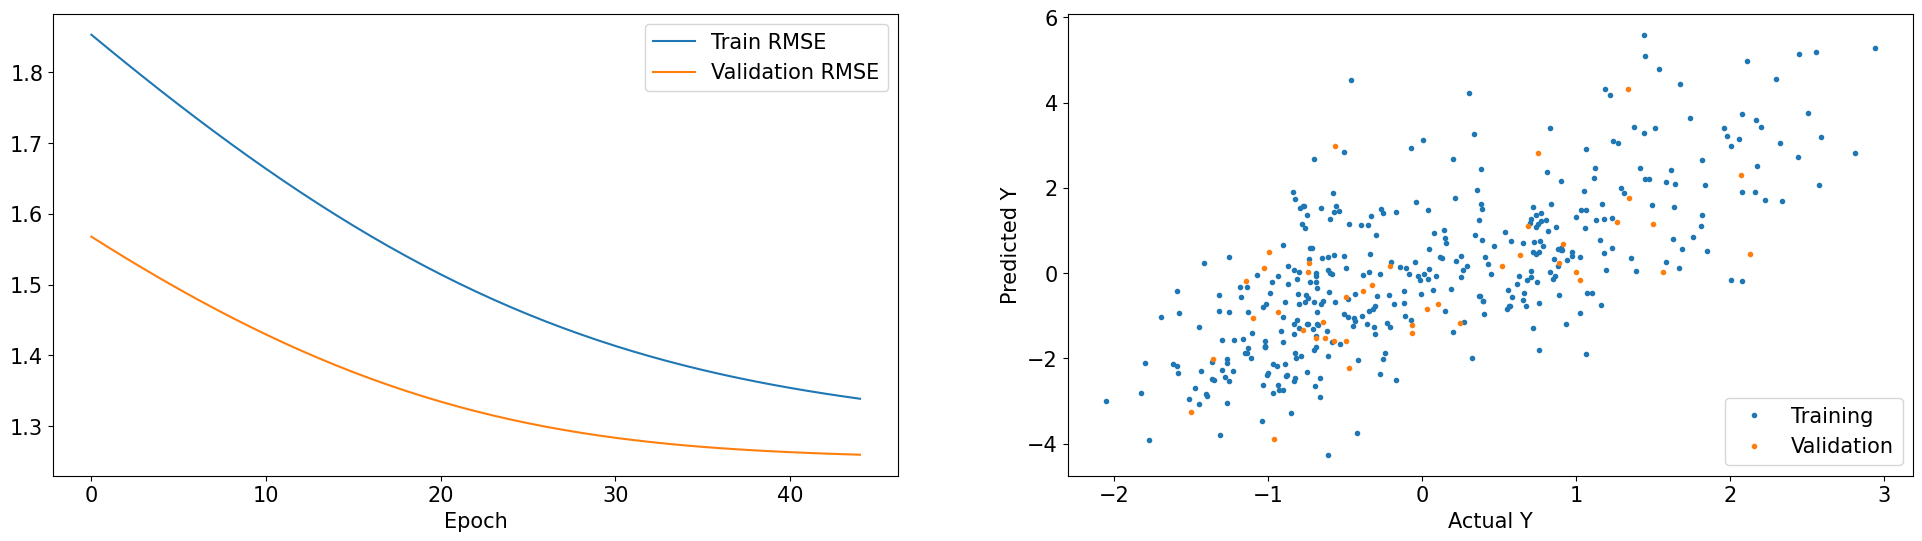

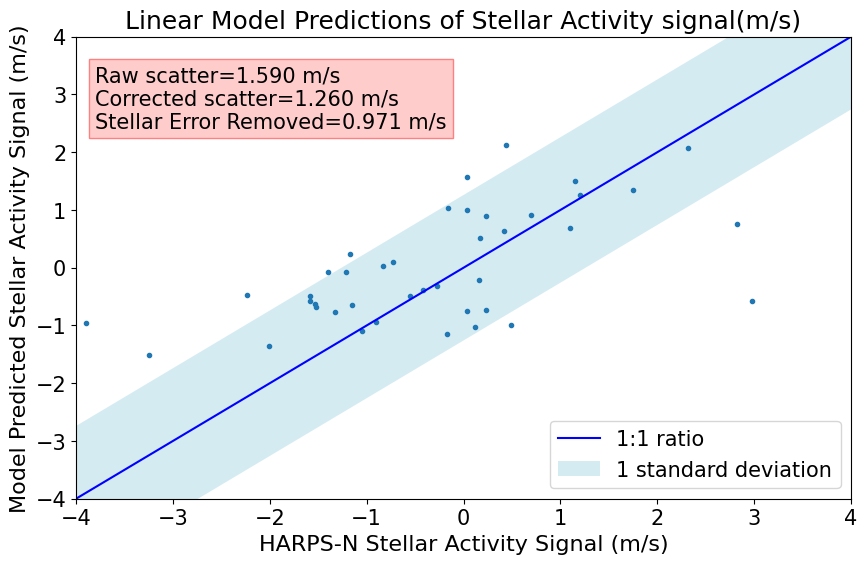

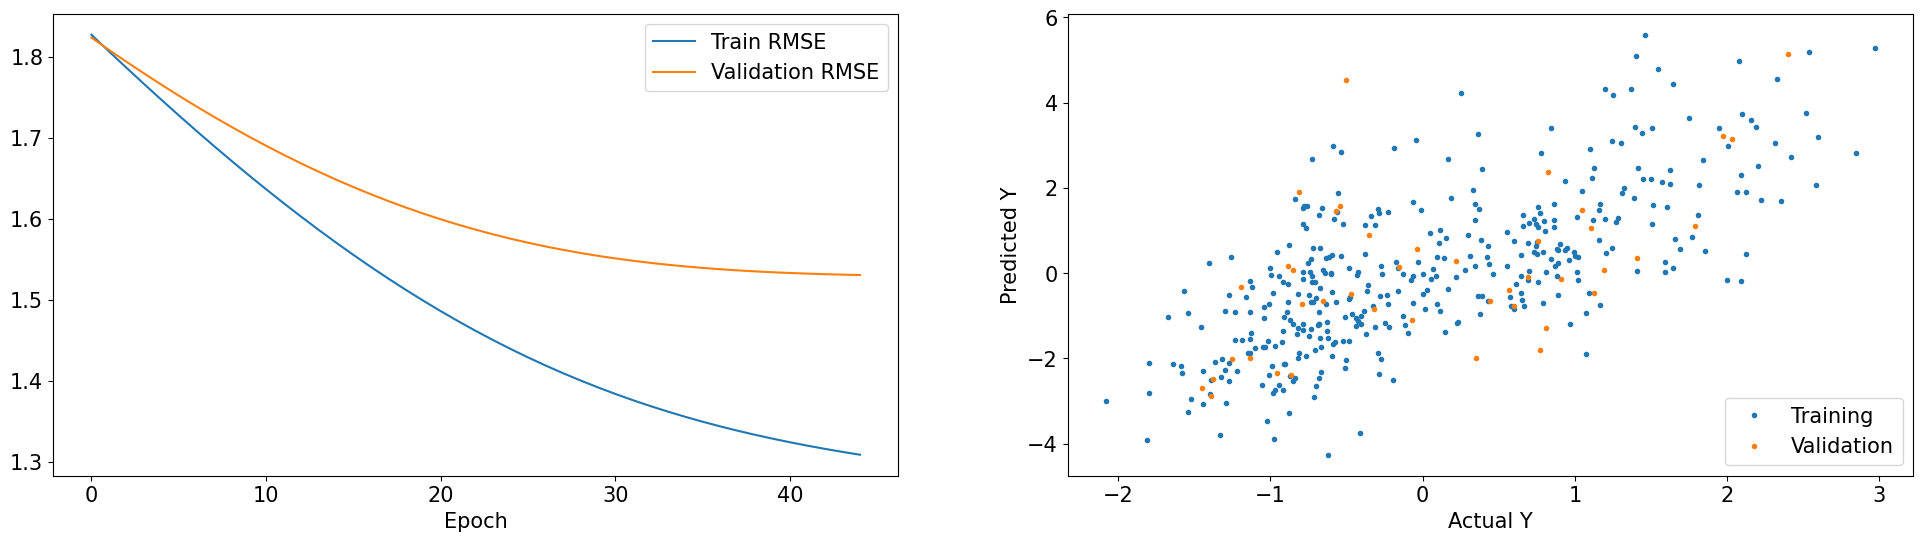

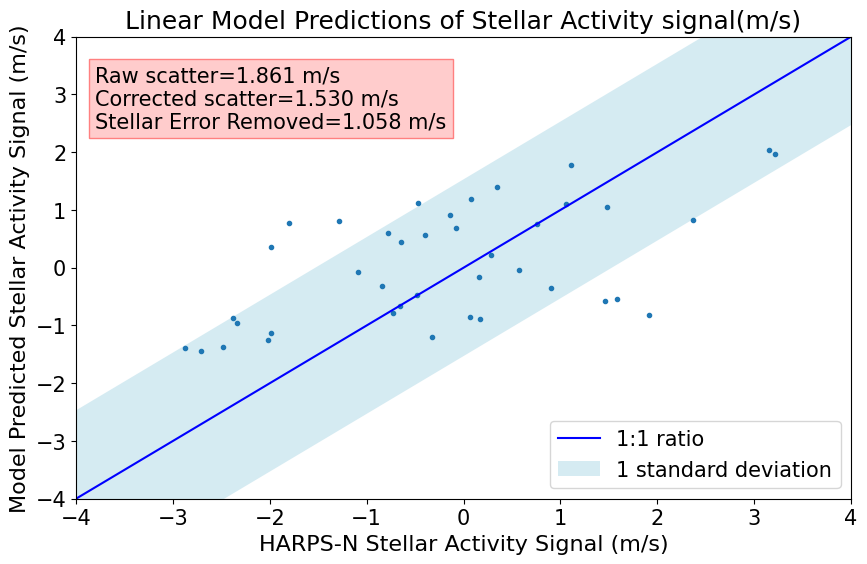

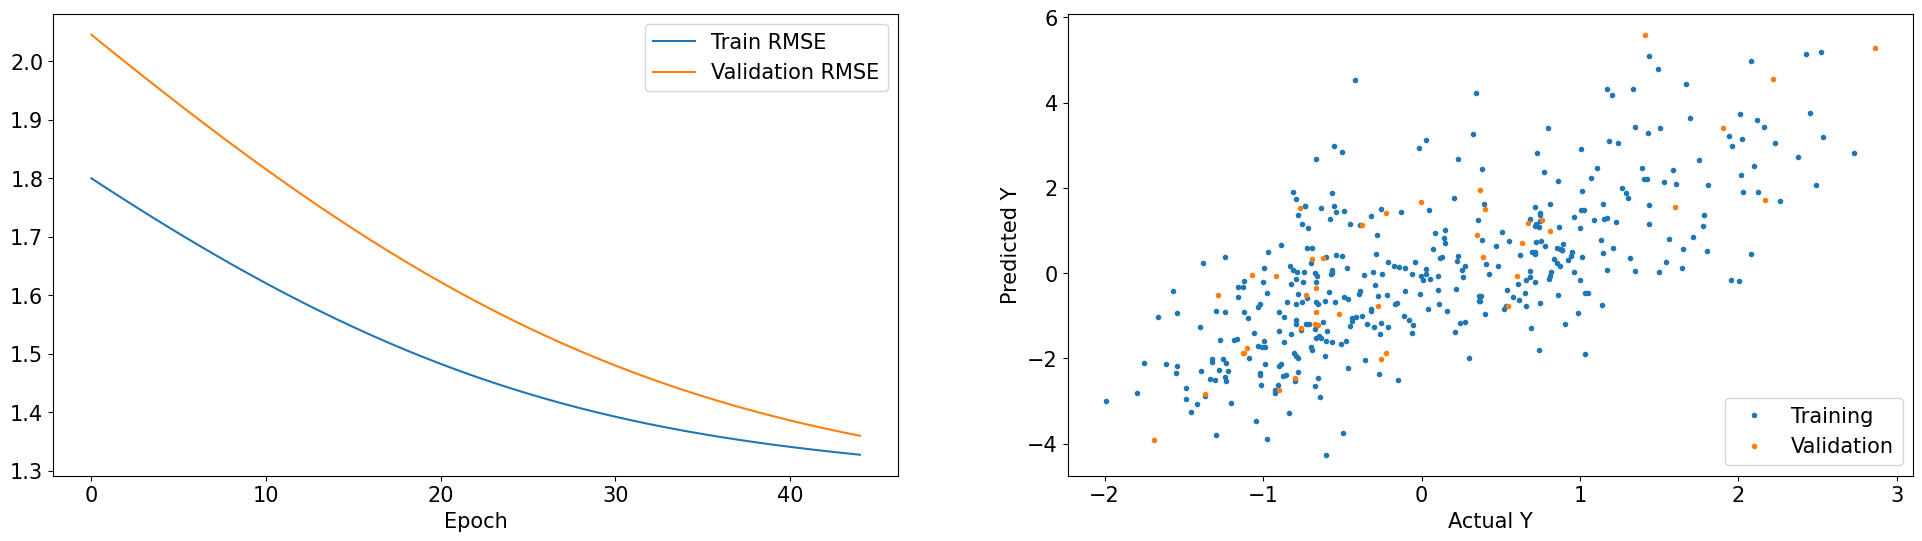

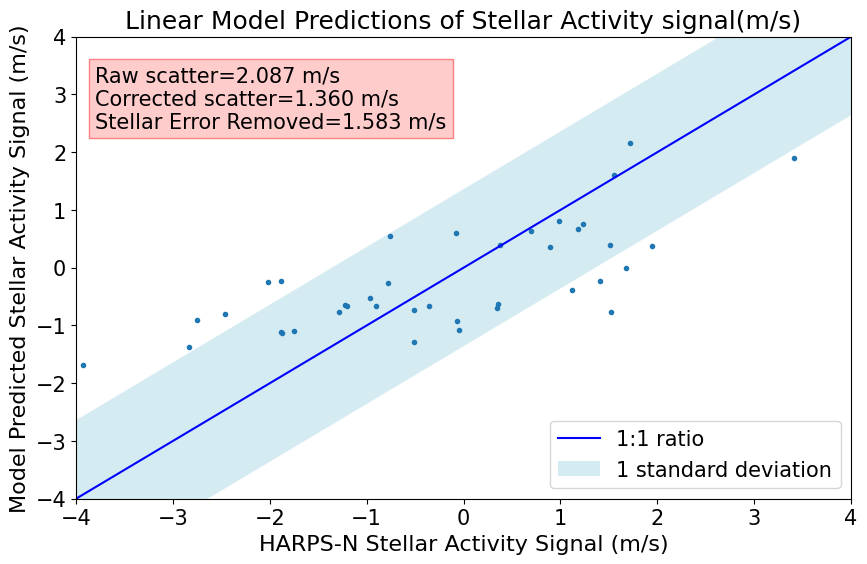

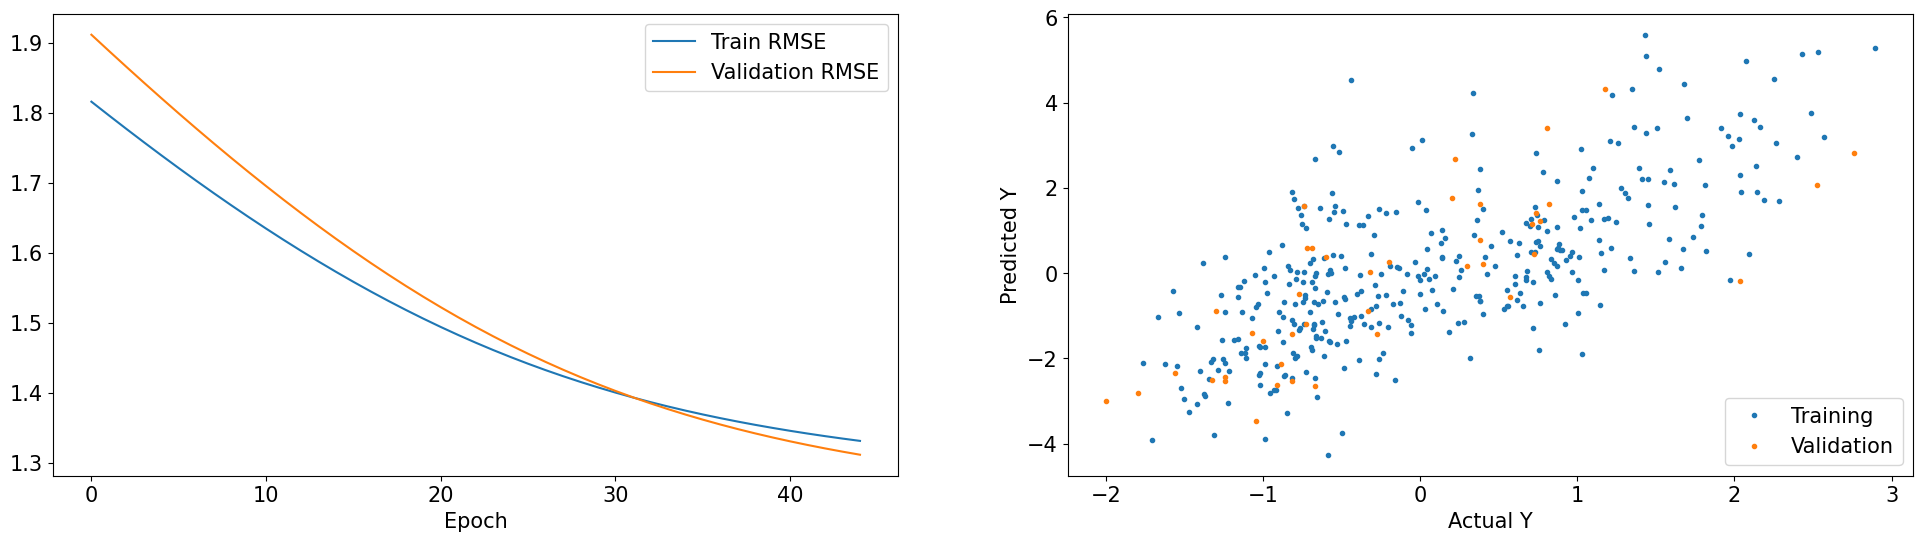

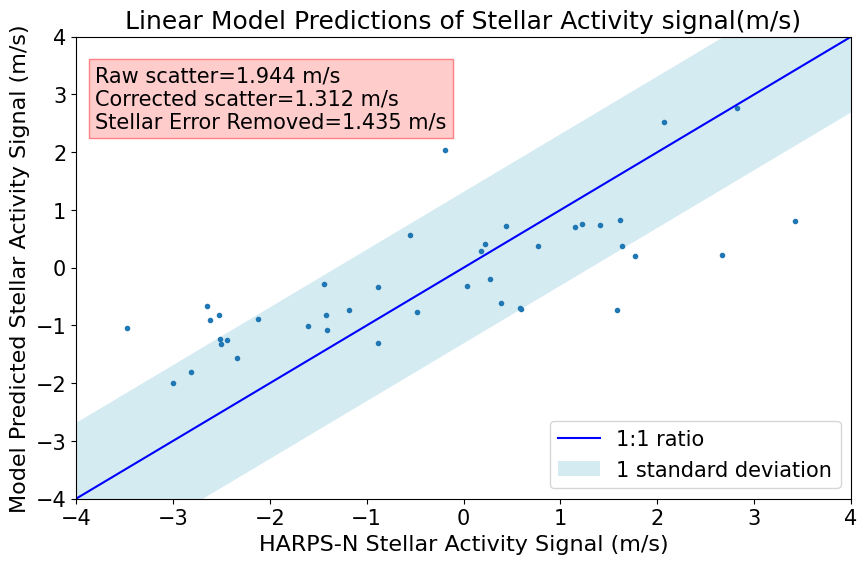

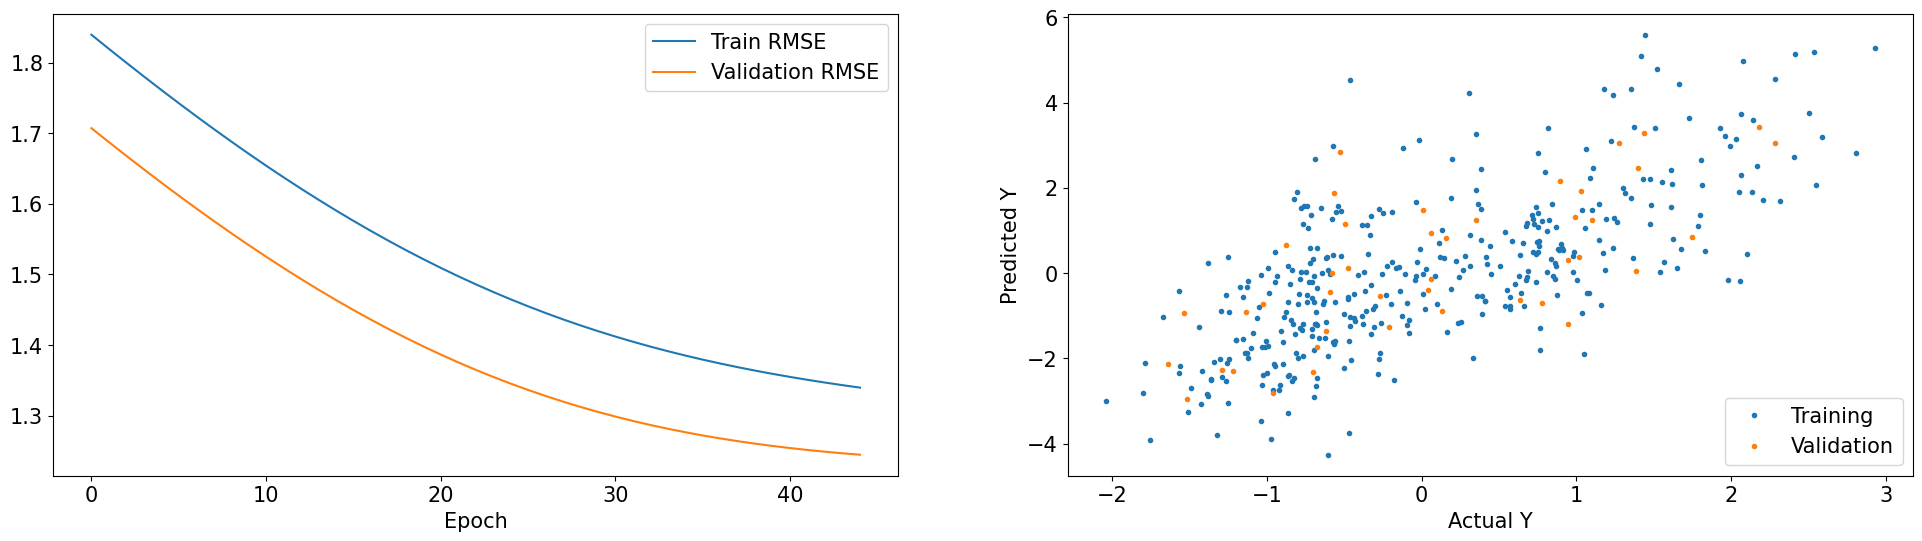

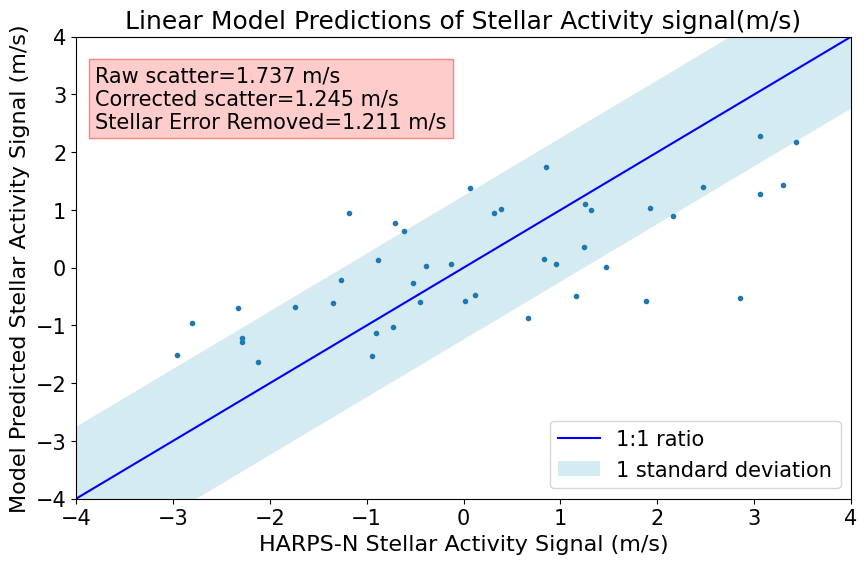

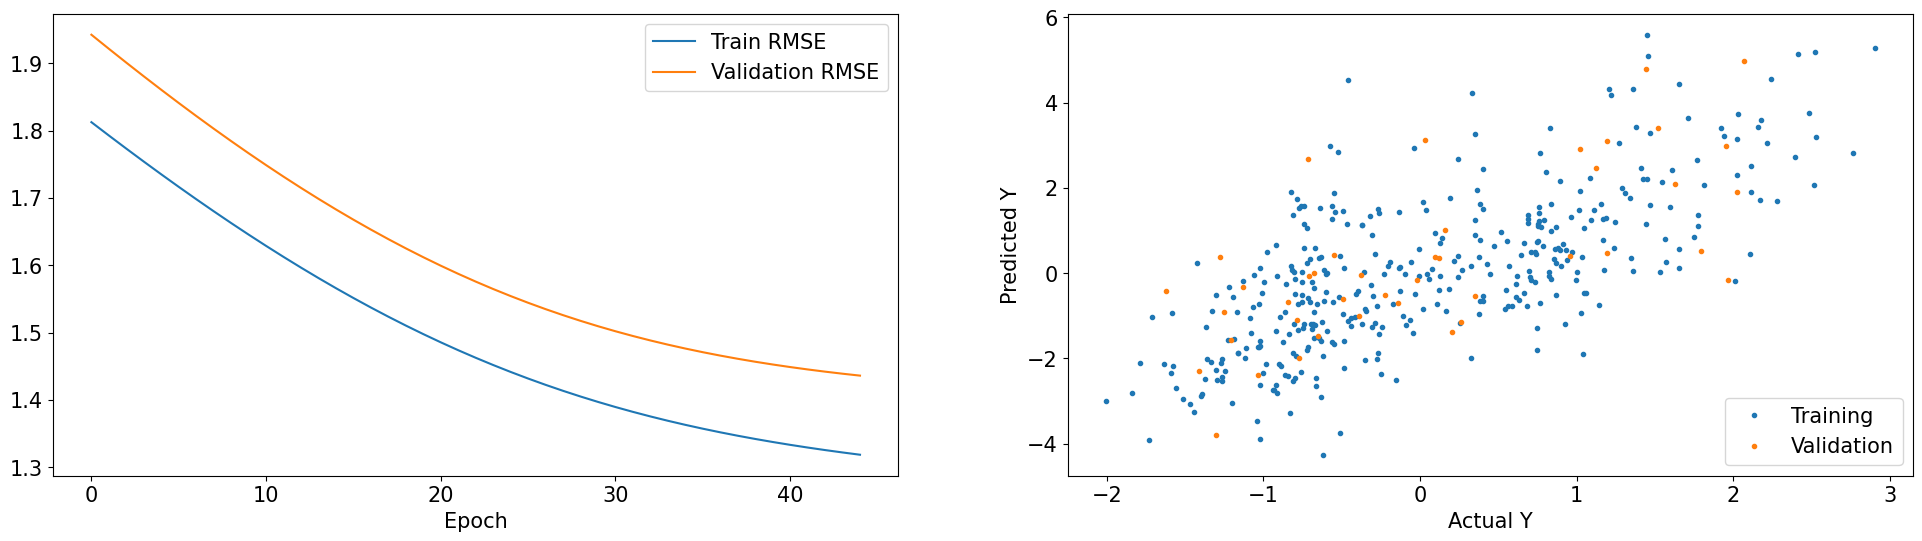

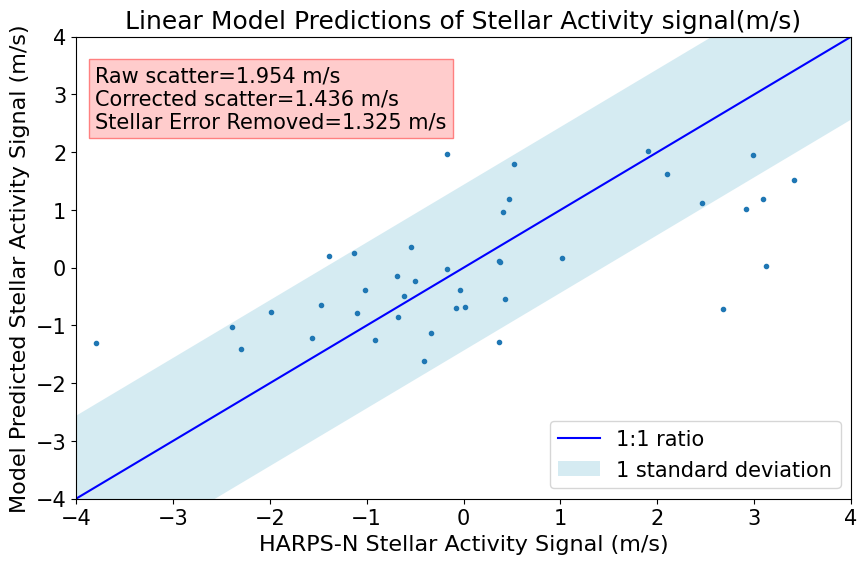

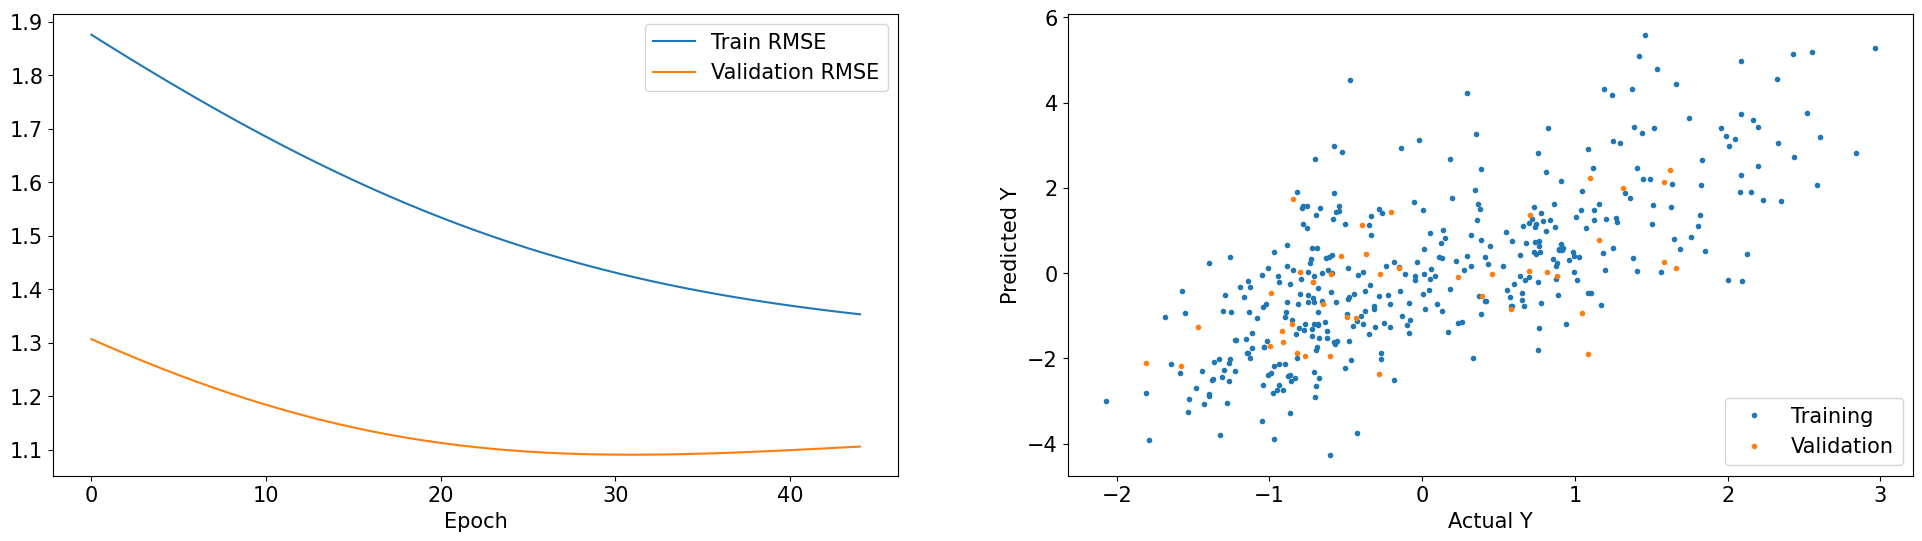

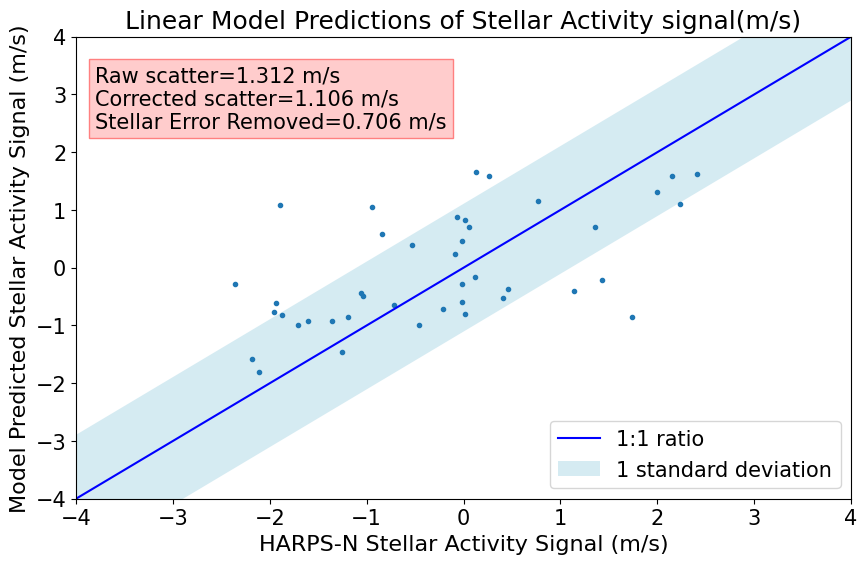

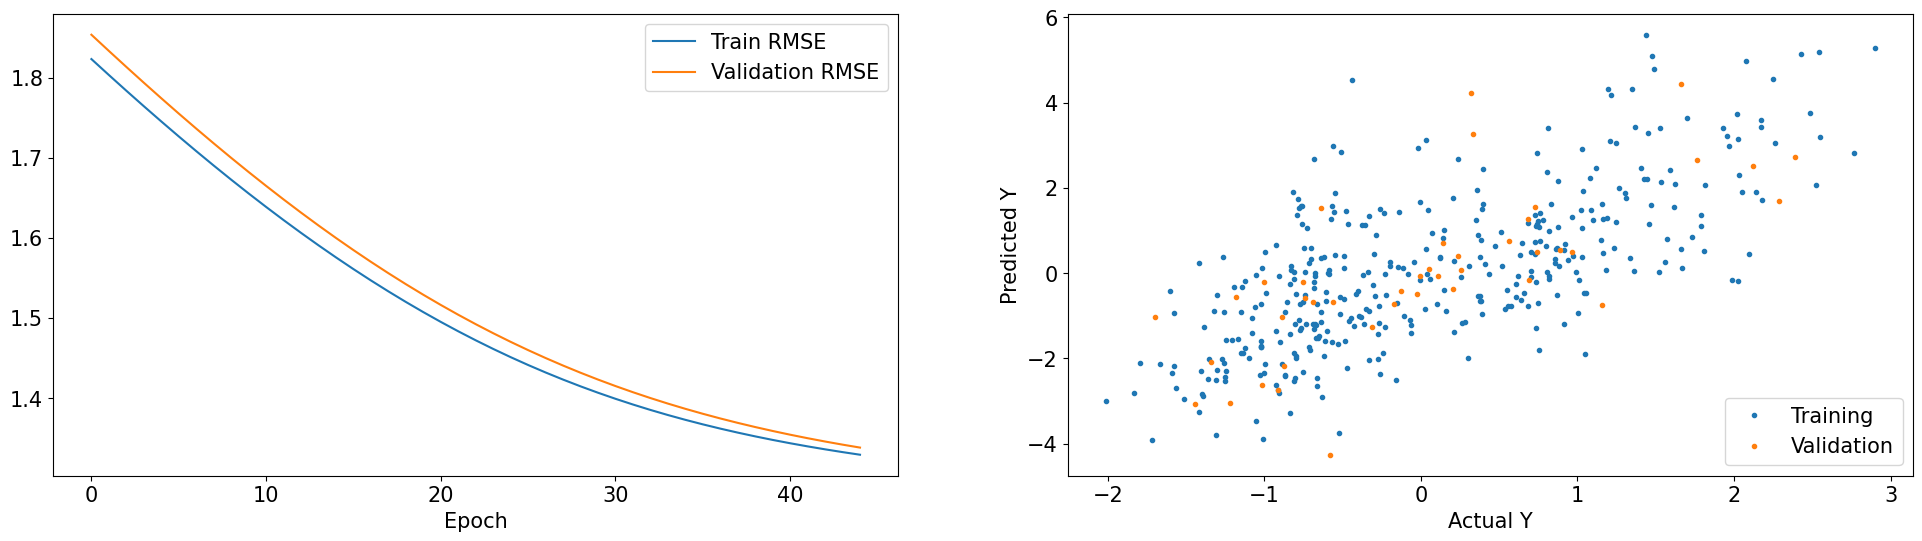

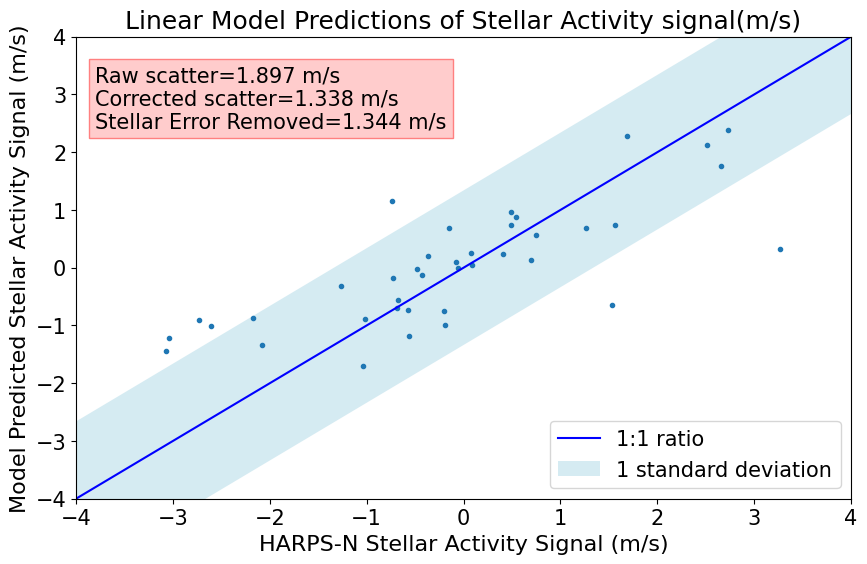

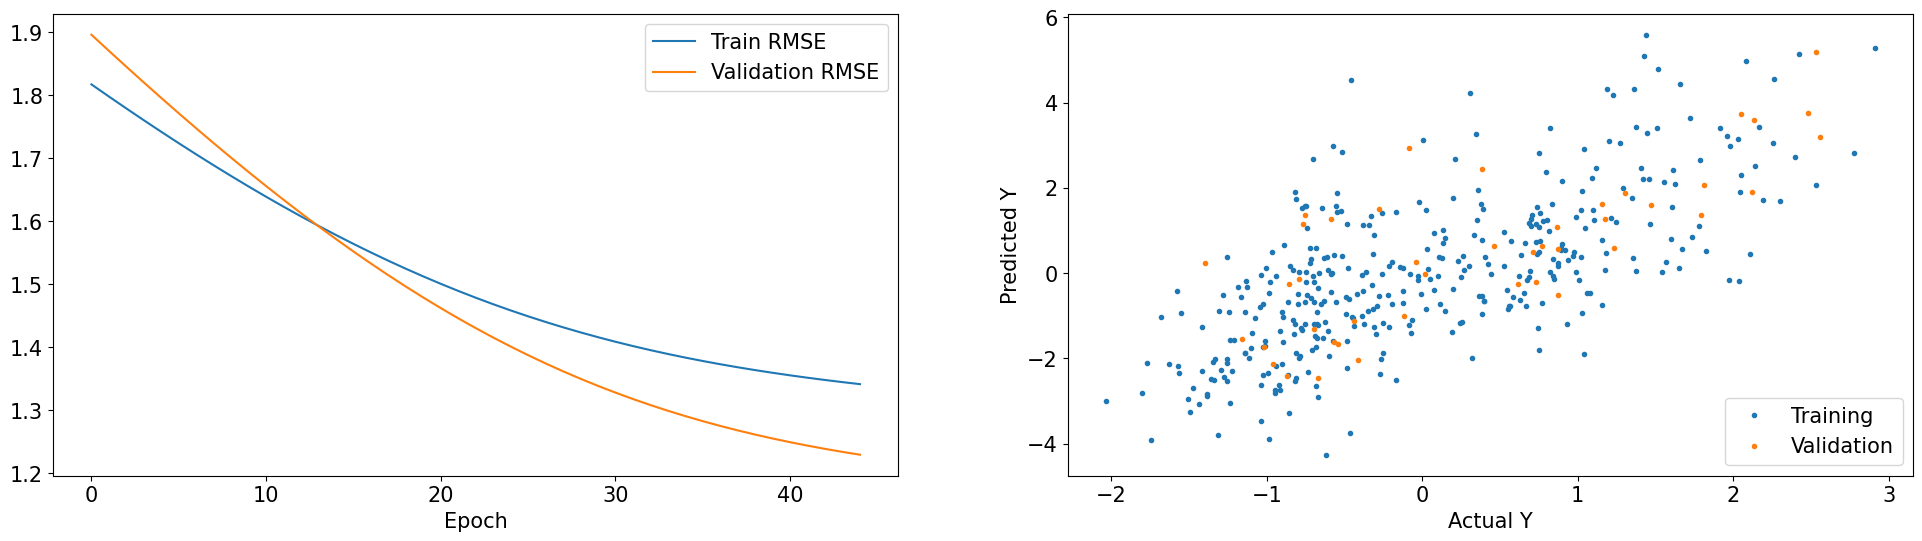

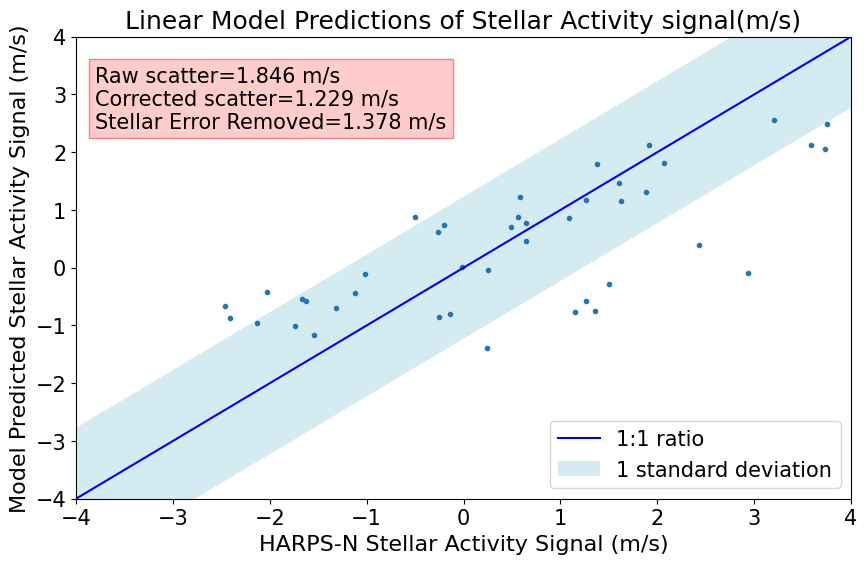

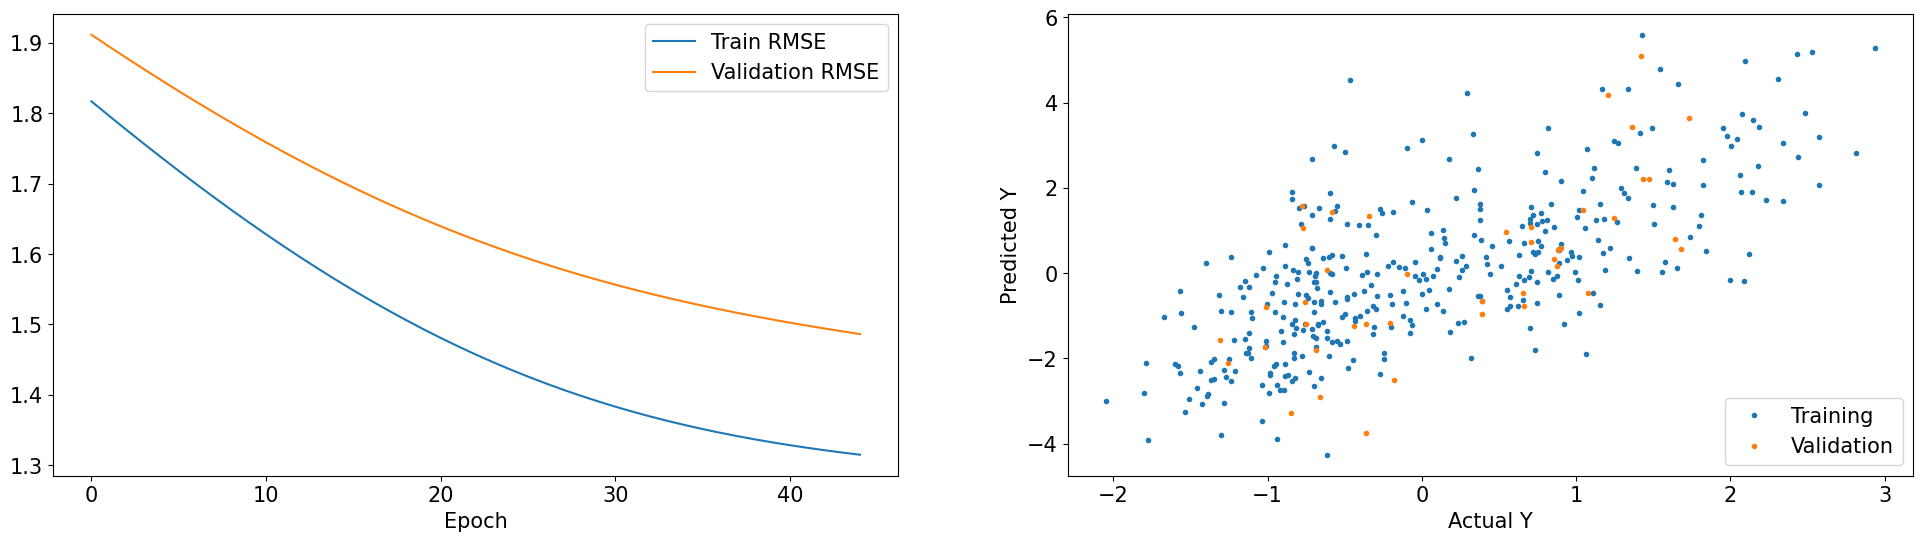

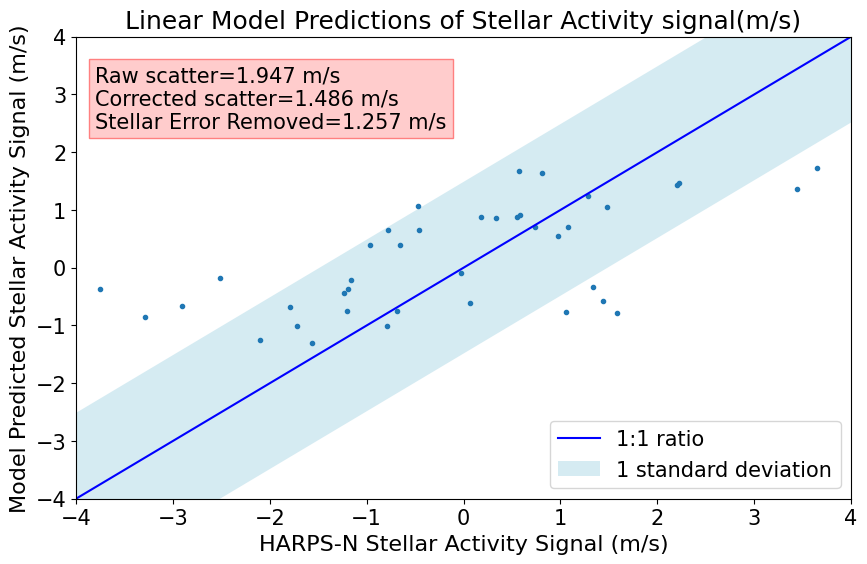

In [13]:
# @title Linear NN Model run (Updated)

print("Starting Linear NN Model Run...")

rms_avg_list = []
weight_decay_list_t = []
gaussian_noise_list_t = []
rms_x_list = []

all_bjds_val = []
all_pred_val = []
all_labels_val = []
all_mean_val_preds = []
all_mean_val_bjds = []
all_mean_val_labels = []

for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    bjd_run_val = []
    pred_run_val = []
    labels_run_val = []
    all_bjds_val = [] # Re-init for this fold
    
    for k in range(0,1):#10): #should be 10 for a full run
        # Updated to use SimpleNamespace
        hparams = SimpleNamespace(**dict(
          num_features=ccf_len, # Use ccf_len variable
          learning_rate=1e-3,
          momentum=0.9, # Note: AdamW is used in train(), momentum is not used by it
          batch_size=1024,
          weight_decay=1e-5, 
          gaussian_noise_scale=0, 
        ))
        model = LinearModel(hparams)
        train(model, hparams, plots="ON", model_name = "Linear", num_epochs=45)
        print(model)
        print("________________________")
        print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))

    if pred_run_val: # Only calculate mean if list is not empty
        mean_val_preds = np.mean(pred_run_val, axis=0)
        mean_val_labels = np.mean(labels_run_val, axis=0)
        mean_val_bjds = np.mean(bjd_run_val, axis=0)
        all_mean_val_preds.append(mean_val_preds.tolist())
        all_mean_val_labels.append(mean_val_labels.tolist())
        all_mean_val_bjds.append(mean_val_bjds.tolist())
    else:
        print(f"Warning: No predictions recorded for fold {index+1}")

avg = np.mean(rms_avg_list)
print("________________________")
print(f"Final Average RMS: {avg}")

#flatten the lists
all_mean_val_preds_flat = [item for sublist in all_mean_val_preds for item in sublist]
all_mean_val_labels_flat = [item for sublist in all_mean_val_labels for item in sublist]
all_mean_val_bjds_flat = [item for sublist in all_mean_val_bjds for item in sublist]

labels: sd: 1.828489325560009
corrected rv: sd: 1.3369428582968879
____________________________________________
labels: MAD*1.4826: 1.7439014172434806
corrected rv: MAD*1.4826: 1.2287358773946762
____________________________________________
labels: 68 percent/2: 1.7452754235267638
corrected rv: 68 percent/2: 1.249488425254822


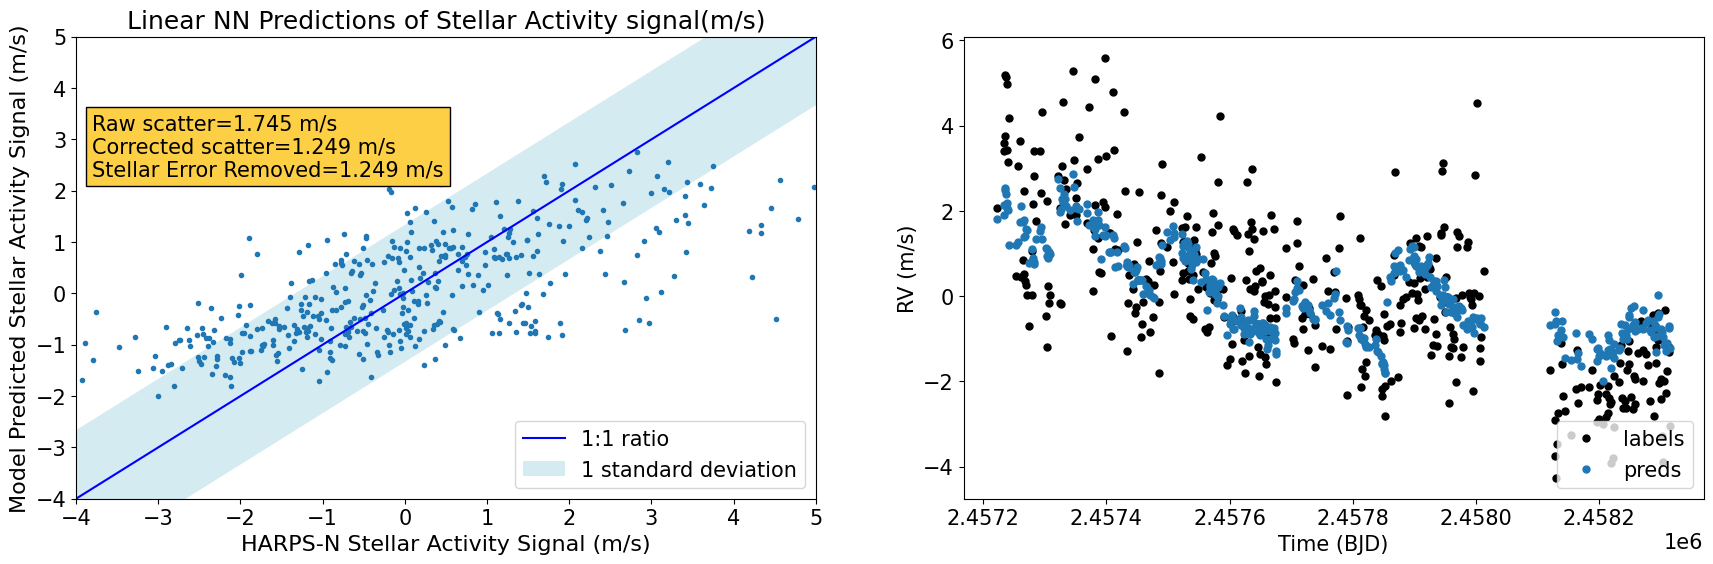

In [14]:
if all_mean_val_labels_flat: # Only run if predictions were made
    df = pd.DataFrame(list(zip(all_mean_val_labels_flat, all_mean_val_preds_flat, all_mean_val_bjds_flat)), 
                   columns =['labels', 'preds', 'BJD']) 
    df_sorted = df.sort_values(by=['BJD'])
    #df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_linearNN_06_30_2021.xlsx', index = False)

    # calculation of scatter removed
    from astropy.stats import median_absolute_deviation

    #df_sorted = df_from_excel
    labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
    labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
    preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

    corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
    corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
    corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

    sd_labels = np.std(df_sorted["labels"], ddof=1)
    sd_corrected_rv = np.std(corrected_rvs, ddof=1)
    rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


    print("labels: sd: "+str(sd_labels))
    print("corrected rv: sd: "+str(sd_corrected_rv))
    print("____________________________________________")
    print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
    print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
    print("____________________________________________")
    print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
    print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


    # plot the average results
    # Scatter reduction plot
    sd_x = np.std(all_mean_val_labels_flat, ddof=1)
    rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels_flat - np.array(all_mean_val_preds_flat))))
    # rms_x_list.append(rms_x) # This list is from the training loop, may be confusing here
    # rms_avg_list.append(rms_x)
    stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
    x_range = np.linspace(-4,5.5, 17)
    upper_bound = x_range+rms_x
    lower_bound = x_range-rms_x

    # plot the scatter reduction plot
    fig, ax = plt.subplots(1, 2, figsize=(21, 6))
    ax1 = ax[0]
    ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
    ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
    #ax.plot(x_range,z[0]*x_range+z[1], color="blue")
    rms_fill=rms_x#0.15
    ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                    alpha=0.5, label="1 standard deviation")
    ax1.set_xlim(-4, 5);
    ax1.set_ylim(-4, 5);
    ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
    ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
    ax1.set_title("Linear NN Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
    #hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
    textstr = '\n'.join((
        r'Raw scatter=%.3f m/s' % (labels_68_percent_by_2, ),
        r'Corrected scatter=%.3f m/s' % (corrected_rvs_68_percent_by_2, ),
        r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
    ax1.text(-3.8, 3.5, textstr, size=15,
            ha="left", va="top",
            bbox=dict(facecolor='#fdcf44',edgecolor='k',
                      boxstyle="square",
                      #ec=(1., 0.5, 0.5),
                      #fc=(1., 0.8, 0.8),
                      ))
    ax1.legend(loc="lower right")

    # plot predictions over time
    ax2 = ax[1]
    ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
             markersize=10,label="labels")
    ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
             label="preds")
    ax2.set_xlabel("Time (BJD)")
    ax2.set_ylabel("RV (m/s)")
    ax2.legend(loc="lower right")
else:
    print("Skipping Linear NN plots because no predictions were generated.")

## Ridge Regression

In [15]:
# @title DatasetBuilder for Ridge (Updated)
class DatasetBuilder(object):
    """Dataset builder class."""

    def __init__(self, file_pattern, hparams, is_training, ccf_len, repeat=1):
        """Initializes the dataset builder.
        Args:
          file_pattern: File pattern matching input file shards, e.g.
            "/tmp/train-?????-of-00100".
          hparams: A SimpleNamespace.
          is_training: Boolean, whether to shuffle.
          ccf_len: Integer, length of the CCF feature.
          repeat: The number of times to repeat the dataset. If None, the dataset
            will repeat indefinitely.
        """
        self.file_pattern = file_pattern
        self.hparams = hparams
        self.is_training = is_training
        self.repeat = repeat
        self.ccf_len = ccf_len

    def __call__(self):
        is_training = self.is_training

        # Dataset of file names.
        filename_dataset = tf.data.Dataset.list_files(self.file_pattern,
                                                      shuffle=is_training)

        # Dataset of serialized tf.Examples.
        dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)

        # Shuffle in training mode.
        if is_training:
            dataset = dataset.shuffle(self.hparams.shuffle_values_buffer)

        # Possibly repeat.
        if self.repeat != 1:
            dataset = dataset.repeat(self.repeat)

        def _example_parser(serialized_example):
            """Parses a single tf.Example into feature and label tensors."""
            data_fields = {
                self.hparams.ccf_feature_name: tf.io.FixedLenFeature([self.ccf_len], tf.float32),
                self.hparams.label_feature_name: tf.io.FixedLenFeature([], tf.float32),
                self.hparams.label_feature_name2: tf.io.FixedLenFeature([], tf.float32),
            }
            parsed_fields = tf.io.parse_single_example(serialized_example, features=data_fields)
            ccf_data = parsed_fields[self.hparams.ccf_feature_name]
            label = parsed_fields[self.hparams.label_feature_name]
            label *= self.hparams.label_rescale_factor  # Rescale the label.
            label2 = parsed_fields[self.hparams.label_feature_name2]
            return {
                "ccf_data": ccf_data,
                "label": label,
                "bjd": label2,
            }

        # Map the parser over the dataset.
        dataset = dataset.map(_example_parser, num_parallel_calls=tf.data.AUTOTUNE)

        # Batch results by up to batch_size.
        dataset = dataset.batch(self.hparams.batch_size)

        # Prefetch a few batches.
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

In [16]:
# @title load_dataset_ridge (Updated)
def load_dataset_ridge(filename, ccf_len):
    dataset_hparams = SimpleNamespace(**dict(
        ccf_feature_name='Rescaled CCF_residuals_cutoff',#"Rescaled CCF_residuals", #CCF_residuals
        label_feature_name= "activity signal",#"RV",
        label_feature_name2= "BJD",
        batch_size=300,
        label_rescale_factor=1000,
        shuffle_values_buffer=1000, # Added for completeness, though not used in eval
      ))
    # Updated DatasetBuilder call
    dataset = DatasetBuilder(filename, dataset_hparams, is_training=False, ccf_len=ccf_len)()
    
    ccf_data_list, labels_list, bjds_list = [], [], []
    for batch in dataset:
        ccf_data_list.append(batch["ccf_data"].numpy())
        labels_list.append(batch["label"].numpy())
        bjds_list.append(batch["bjd"].numpy())

    if not ccf_data_list:
        print(f"Warning: No data loaded from {filename}")
        return np.array([]), np.array([]), np.array([])

    ccf_data = np.concatenate(ccf_data_list)
    labels = np.concatenate(labels_list)
    bjds = np.concatenate(bjds_list)
    
    assert len(ccf_data.shape) == 2
    assert len(labels.shape) == 1
    assert len(bjds.shape) == 1
    assert ccf_data.shape[0] == labels.shape[0]
    #print("Read dataset with {} examples".format(labels.shape[0]))
    return ccf_data, labels, bjds

In [17]:
# @title ridge_regress_harps (No TF changes needed)
def ridge_regress_harps(TRAIN_FILE_NAME_LIST, VAL_FILE_NAME_LIST, alpha, verbose, ccf_len):
    rms_avg_list = []
    weight_decay_list_t = []
    gaussian_noise_list_t = []
    rms_x_list = []

    all_bjds_val = []
    all_pred_val = []
    all_labels_val = []
    all_mean_val_preds = []
    all_mean_val_bjds = []
    all_mean_val_labels = []
    all_mean_val_bjds = []
    avg_list = []

    for index in range(0, len(VAL_FILE_NAME_LIST)):
        TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
        VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
        train_X, train_Y, train_bjd  = load_dataset_ridge(TRAIN_FILE_NAME, ccf_len)
        val_X, val_Y, val_bjd = load_dataset_ridge(VAL_FILE_NAME, ccf_len)

        if train_X.size == 0 or val_X.size == 0:
            print(f"Skipping fold {index+1} due to missing data.")
            continue

        pred_run_val = []
        labels_run_val = []
        bjd_run_val = []
        for k in range(0,10):
            model = Ridge(alpha=alpha).fit(train_X, train_Y)
            val_pred_Y = model.predict(val_X)
            pred_run_val.append(val_pred_Y)
            labels_run_val.append(val_Y)
            bjd_run_val.append(val_bjd)
            rms_avg = np.sqrt(np.mean(np.square(val_Y -val_pred_Y)))
            rms_avg_list.append(rms_avg)
            if verbose == True:
                print(model)
                print("________________________")
                print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
                print("rms: "+str(rms_avg))
            else:
                continue
        if pred_run_val: # Check if list is populated
            mean_val_preds = np.mean(pred_run_val, axis=0)
            mean_val_labels = np.mean(labels_run_val, axis=0)
            mean_val_bjds = np.mean(bjd_run_val, axis=0)
            all_mean_val_preds.append(mean_val_preds.tolist())
            all_mean_val_labels.append(mean_val_labels.tolist())
            all_mean_val_bjds.append(mean_val_bjds.tolist())
    
    if rms_avg_list:
        avg = np.mean(rms_avg_list)
        avg_list.append(avg)
        print("________________________")
        print("average rms = "+str(avg)+" m/s")
    else:
        print("No RMS values to average.")
        avg_list.append(np.nan)

    #flatten the lists
    all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
    all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
    all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]
  
    return all_mean_val_preds, all_mean_val_labels, all_mean_val_bjds, avg_list, alpha

In [18]:
# Cross validation Ridge Regression Model Run (10 times)

all_mean_val_preds_ridge, all_mean_val_labels_ridge, all_mean_val_bjds_ridge, avg_rms_list_ridge, alpha_ridge = ridge_regress_harps(TRAIN_FILE_NAME_LIST, 
                                                                                 VAL_FILE_NAME_LIST, 
                                                                                 alpha=3.6094,#340.010636,#9.469, #340.010636,	#335.734079,#9.469, 
                                                                                 verbose=False,
                                                                                 ccf_len = ccf_len)

________________________
average rms = 1.0802248 m/s


labels: sd: 1.828489322467377
corrected rv: sd: 1.0849648309077178
____________________________________________
labels: MAD*1.4826: 1.7439013288736342
corrected rv: MAD*1.4826: 1.0854721516504884
____________________________________________
labels: 68 percent/2: 1.7452755212783813
corrected rv: 68 percent/2: 1.096999578475952


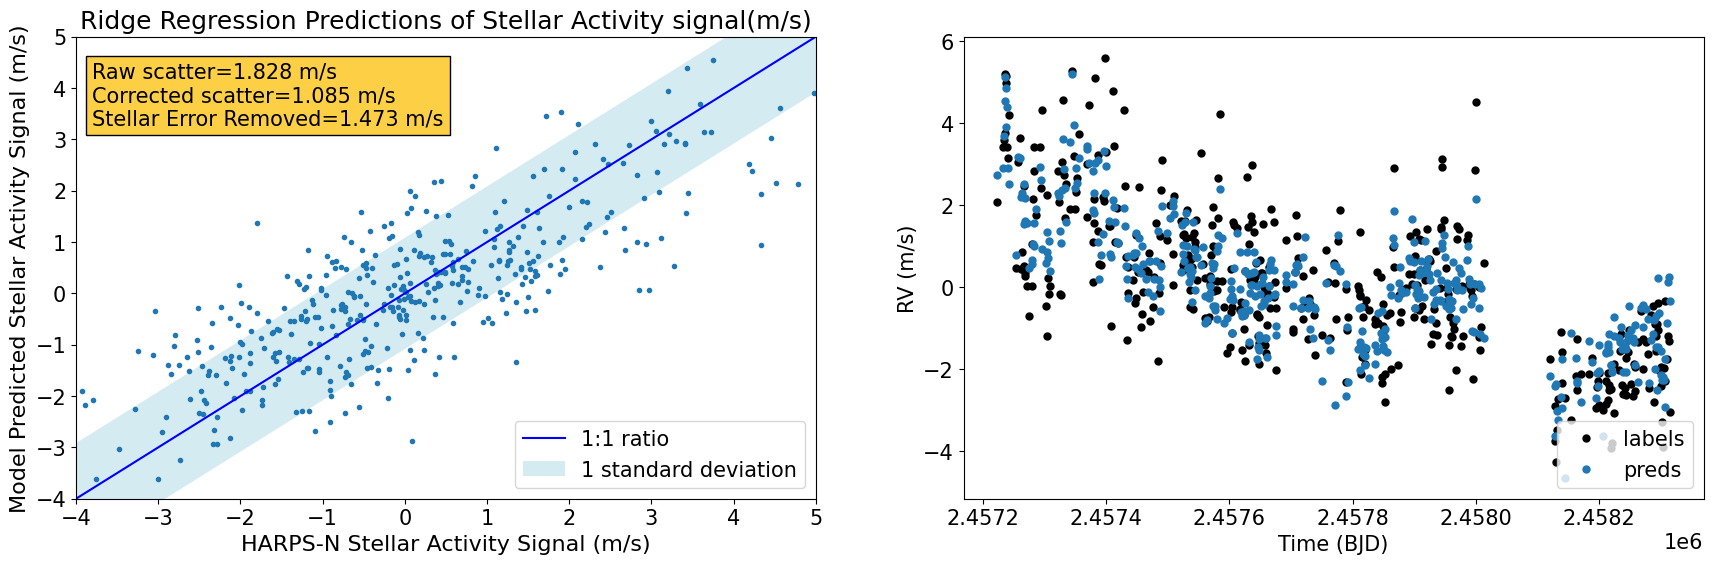

In [19]:
if all_mean_val_labels_ridge: # Only run if predictions were made
    df = pd.DataFrame(list(zip(all_mean_val_labels_ridge, all_mean_val_preds_ridge, all_mean_val_bjds_ridge)), 
                   columns =['labels', 'preds', 'BJD']) 
    df_sorted = df.sort_values(by=['BJD'])
    #df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_ridge_06_30_2021.xlsx', index = False)

    # calculation of scatter removed
    from astropy.stats import median_absolute_deviation

    #df_sorted = df_from_excel
    labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
    labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
    preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

    corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
    corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
    corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

    sd_labels = np.std(df_sorted["labels"], ddof=1)
    sd_corrected_rv = np.std(corrected_rvs, ddof=1)
    rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


    print("labels: sd: "+str(sd_labels))
    print("corrected rv: sd: "+str(sd_corrected_rv))
    print("____________________________________________")
    print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
    print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
    print("____________________________________________")
    print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
    print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


    # plot the average results
    # Scatter reduction plot
    rms_avg_list = []
    sd_x = np.std(all_mean_val_labels_ridge, ddof=1)
    rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels_ridge - np.array(all_mean_val_preds_ridge))))
    #rms_x_list.append(rms_x)
    rms_avg_list.append(rms_x)
    stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
    x_range = np.linspace(-4,5.5, 17)
    upper_bound = x_range+rms_x
    lower_bound = x_range-rms_x

    # plot the scatter reduction plot
    fig, ax = plt.subplots(1, 2, figsize=(21, 6))
    ax1 = ax[0]
    ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
    ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
    #ax.plot(x_range,z[0]*x_range+z[1], color="blue")
    rms_fill=rms_x#0.15
    ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                    alpha=0.5, label="1 standard deviation")
    ax1.set_xlim(-4, 5);
    ax1.set_ylim(-4, 5);
    ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
    ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
    ax1.set_title("Ridge Regression Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
    #hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
    textstr = '\n'.join((
        r'Raw scatter=%.3f m/s' % (sd_labels, ),
        r'Corrected scatter=%.3f m/s' % (sd_corrected_rv, ),
        r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
    ax1.text(-3.8, 4.5, textstr, size=15,
            ha="left", va="top",
            bbox=dict(facecolor='#fdcf44',edgecolor='k',
                      boxstyle="square",
                      #ec=(1., 0.5, 0.5),
                      #fc=(1., 0.8, 0.8),
                      ))
    ax1.legend(loc="lower right")

    # plot predictions over time
    ax2 = ax[1]
    ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
             markersize=10,label="labels")
    ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
             label="preds")
    ax2.set_xlabel("Time (BJD)")
    ax2.set_ylabel("RV (m/s)")
    ax2.legend(loc="lower right")
else:
    print("Skipping Ridge Regression plots because no predictions were generated.")

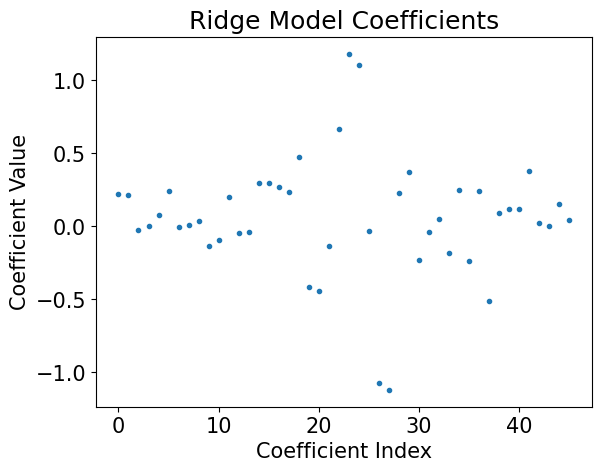

0.0 1.0


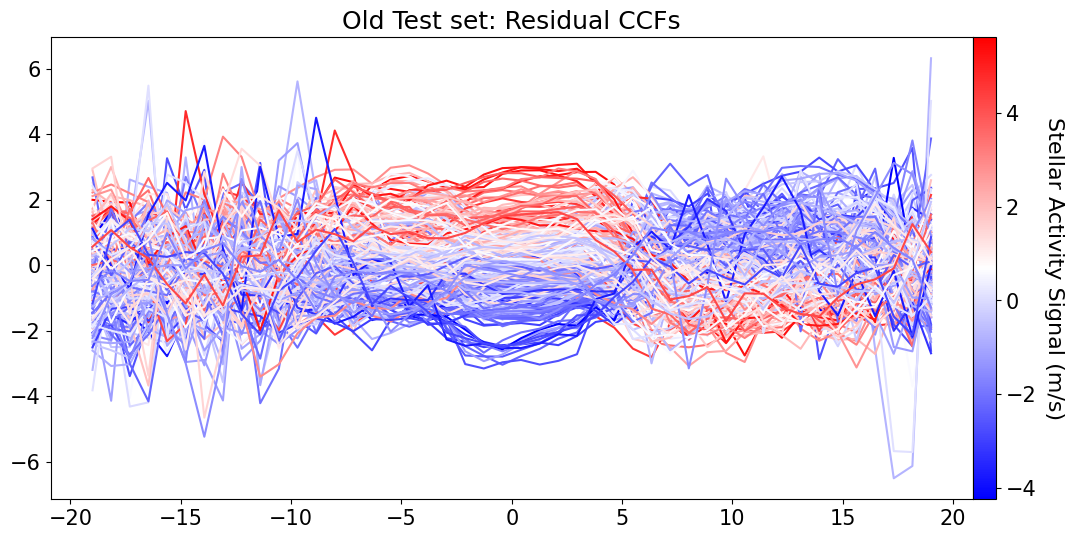

In [20]:
if all_mean_val_labels_ridge: # Only run if previous cell worked
    index=0
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    train_X, train_Y, train_bjd  = load_dataset_ridge(TRAIN_FILE_NAME, ccf_len)
    val_X, val_Y, val_bjd = load_dataset_ridge(VAL_FILE_NAME, ccf_len)
    model = Ridge(alpha=alpha_ridge).fit(train_X, train_Y)
    plt.plot(model.coef_, ".")
    plt.title("Ridge Model Coefficients")
    plt.xlabel("Coefficient Index")
    plt.ylabel("Coefficient Value")
    plt.show()
    
    residual_plot(train_Y, np.linspace(-19,19,ccf_len), train_X, "median","Old Test set: Residual CCFs")
else:
    print("Skipping Ridge coefficient plot, no model trained.")

0.0 1.0


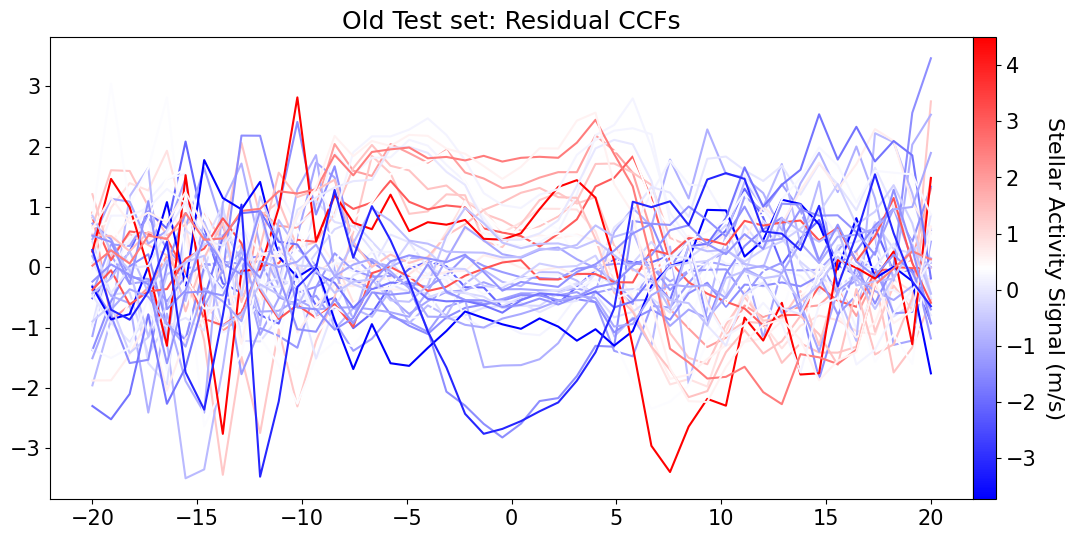

In [21]:
if 'val_Y' in locals(): # Check if val_Y was defined in the previous cell
    # Plot old dataset
    residual_plot(val_Y, np.linspace(-20,20,ccf_len), val_X, "median","Old Test set: Residual CCFs")

    df_old = pd.DataFrame(list(zip(val_Y,val_X, val_bjd)), columns =['val_Y', 'val_X', 'BJD']) 
    df_old_sorted = df_old.sort_values(by=['BJD'])
    df_old_sorted = df_old_sorted.reset_index(drop=True)
else:
    print("Skipping residual plot, val_Y not defined.")

In [22]:
# Alpha cross-val runs

# Cross validation Ridge Regression Model Run (10 times)
alpha_range = np.random.uniform(2, 5.5, 100)
#alpha_range = np.append(alpha_range, 9.469)

alpha_list = []
rms_crossval_list = []
for alpha in tqdm(alpha_range):
    all_mean_val_preds, all_mean_val_labels, all_mean_val_bjds, avg_rms_list, alpha_out = ridge_regress_harps(TRAIN_FILE_NAME_LIST, 
                                                                                  VAL_FILE_NAME_LIST, 
                                                                                  alpha=alpha, 
                                                                                  verbose=False,
                                                                                  ccf_len= ccf_len)
    # compute rms across all crossval slice
    rms_crossval = np.mean(avg_rms_list)
    rms_crossval_list.append(rms_crossval)
    alpha_list.append(alpha)


  0%|          | 0/100 [00:00<?, ?it/s]

________________________
average rms = 1.0808773 m/s
________________________
average rms = 1.0805484 m/s
________________________
average rms = 1.0803888 m/s
________________________
average rms = 1.0803777 m/s


2026-02-02 22:33:53.660933: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


________________________
average rms = 1.0810218 m/s
________________________
average rms = 1.080565 m/s
________________________
average rms = 1.0810201 m/s
________________________
average rms = 1.0810771 m/s
________________________
average rms = 1.0802889 m/s
________________________
average rms = 1.0805235 m/s
________________________
average rms = 1.0804976 m/s
________________________
average rms = 1.0807885 m/s
________________________
average rms = 1.080665 m/s
________________________
average rms = 1.0806183 m/s
________________________
average rms = 1.0802387 m/s
________________________
average rms = 1.0802766 m/s
________________________
average rms = 1.0802276 m/s
________________________
average rms = 1.0811639 m/s
________________________
average rms = 1.080513 m/s
________________________
average rms = 1.081178 m/s
________________________
average rms = 1.0803914 m/s
________________________
average rms = 1.0806385 m/s
________________________
average rms = 1.0803323 m

2026-02-02 22:34:17.344257: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


________________________
average rms = 1.0803502 m/s
________________________
average rms = 1.0814646 m/s
________________________
average rms = 1.0805676 m/s
________________________
average rms = 1.0804183 m/s
________________________
average rms = 1.0802448 m/s
________________________
average rms = 1.0809282 m/s
________________________
average rms = 1.080438 m/s
________________________
average rms = 1.0802443 m/s
________________________
average rms = 1.0805025 m/s
________________________
average rms = 1.0817478 m/s
________________________
average rms = 1.0803325 m/s
________________________
average rms = 1.0805854 m/s
________________________
average rms = 1.0816687 m/s
________________________
average rms = 1.0802294 m/s
________________________
average rms = 1.0802917 m/s
________________________
average rms = 1.0805717 m/s
________________________
average rms = 1.0802759 m/s
________________________
average rms = 1.0803308 m/s
________________________
average rms = 1.080303

In [23]:
df_rms = pd.DataFrame(list(zip(alpha_list, rms_crossval_list)), 
               columns =['alpha_list', 'avg_rms_list'])
df_rms_sorted = df_rms.sort_values(by=['avg_rms_list'])
#df_rms_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/Clean_June28_rv_net_code/crossval_preds/alpha_rms_linear_12_6.xlsx', index = False) 

In [24]:
# This cell tries to read from Google Drive. It will fail unless GDrive is mounted.
# You can mount your drive with the following:
# from google.colab import drive
# drive.mount('/content/gdrive')

try:
    # read in the files
    df_rms_sorted_1 = pd.read_excel('gdrive/Shared drives/Exoplanet_RV/Clean_June28_rv_net_code/crossval_preds/alpha_rms_linear_12_1.xlsx')
    df_rms_sorted_2 = pd.read_excel('gdrive/Shared drives/Exoplanet_RV/Clean_June28_rv_net_code/crossval_preds/alpha_rms_linear_12_1_v2.xlsx')

    # Combine dataframes
    frames = [df_rms_sorted_1, df_rms_sorted_2]
    df_rms_sorted_gdrive = pd.concat(frames)

    df_rms_sorted_gdrive = df_rms_sorted_gdrive.sort_values(by=['avg_rms_list'])
    print(df_rms_sorted_gdrive.head())
except FileNotFoundError:
    print("Could not find Google Drive files. Using results from this run.")
    print(df_rms_sorted.head())

Could not find Google Drive files. Using results from this run.
    alpha_list  avg_rms_list
86    3.556072      1.080227
45    3.723287      1.080227
81    3.726595      1.080227
16    3.551236      1.080228
41    3.747377      1.080229


Best alpha from this run:
alpha_list      3.556072
avg_rms_list    1.080227
Name: 86, dtype: float64


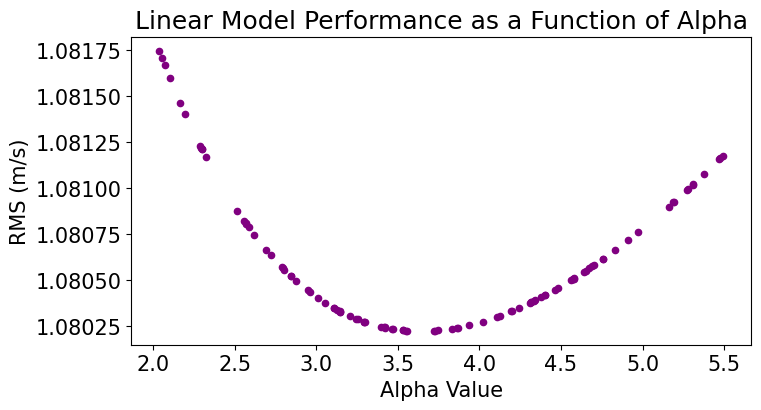

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt.plot(df_rms_sorted["alpha_list"],df_rms_sorted["avg_rms_list"], ".", color='purple',
         markersize=9)
plt.title("Linear Model Performance as a Function of Alpha")
plt.xlabel("Alpha Value")
plt.ylabel("RMS (m/s)")
#plt.xlim(0, 20)
#plt.ylim(0.94, 0.95)

if not df_rms_sorted.empty:
    print("Best alpha from this run:")
    print(df_rms_sorted.iloc[0])

## FC NN Model Run

Starting FC NN Model Run...
1: Train loss: 3.235, Train RMSE: 1.789, Val RMSE: 2.112
10: Train loss: 1.441, Train RMSE: 1.154, Val RMSE: 1.135
20: Train loss: 0.8524, Train RMSE: 0.9242, Val RMSE: 1.263
30: Train loss: 0.3327, Train RMSE: 0.5442, Val RMSE: 1.296
40: Train loss: 0.137, Train RMSE: 0.3677, Val RMSE: 1.302
50: Train loss: 0.05042, Train RMSE: 0.2229, Val RMSE: 1.261
<FCModel name=fc_model, built=True>
________________________
Cross-val number: 1, Run number: 1
1: Train loss: 3.285, Train RMSE: 1.831, Val RMSE: 1.608
10: Train loss: 1.127, Train RMSE: 1.054, Val RMSE: 1.444
20: Train loss: 0.5062, Train RMSE: 0.7522, Val RMSE: 1.432
30: Train loss: 0.2826, Train RMSE: 0.5392, Val RMSE: 1.43
40: Train loss: 0.1023, Train RMSE: 0.3056, Val RMSE: 1.328
50: Train loss: 0.05324, Train RMSE: 0.2173, Val RMSE: 1.392
<FCModel name=fc_model_1, built=True>
________________________
Cross-val number: 2, Run number: 1
1: Train loss: 3.005, Train RMSE: 1.789, Val RMSE: 1.621
10: Train l

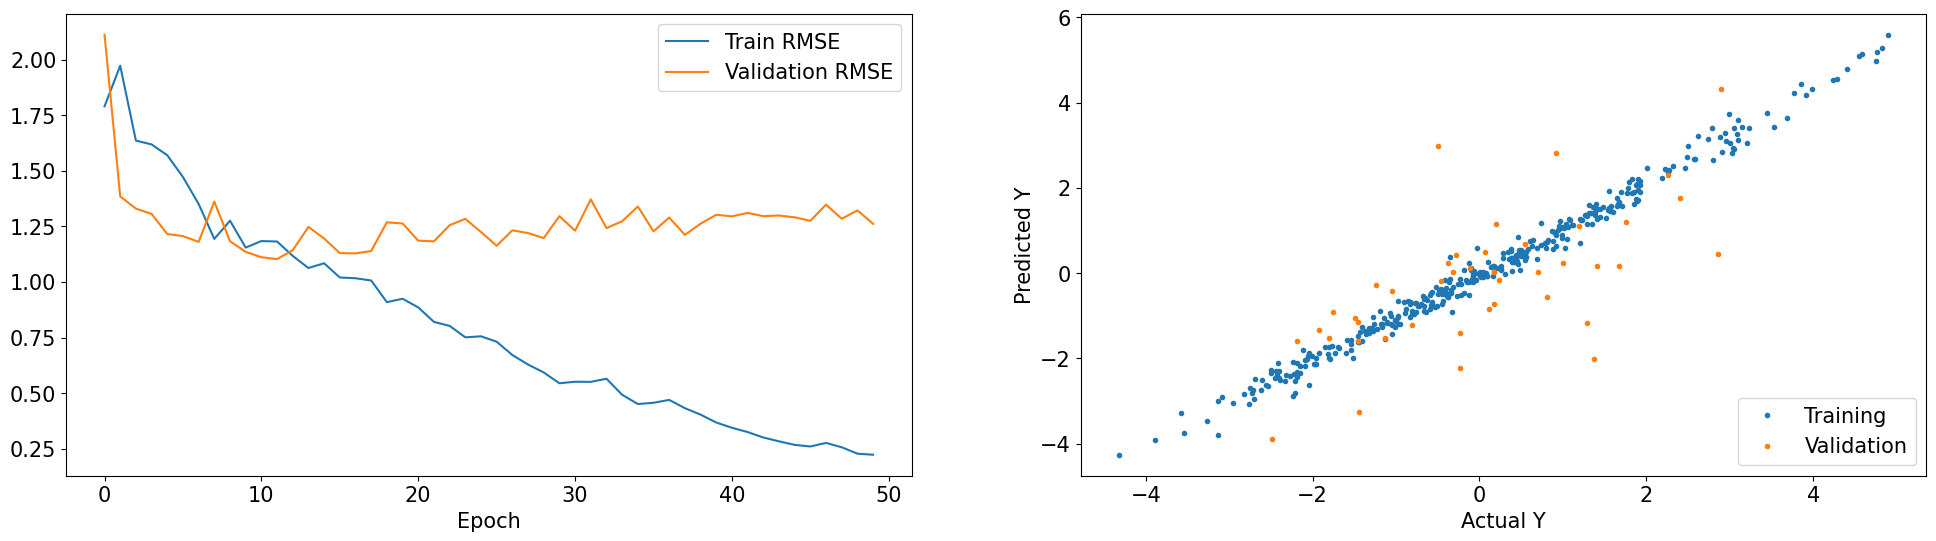

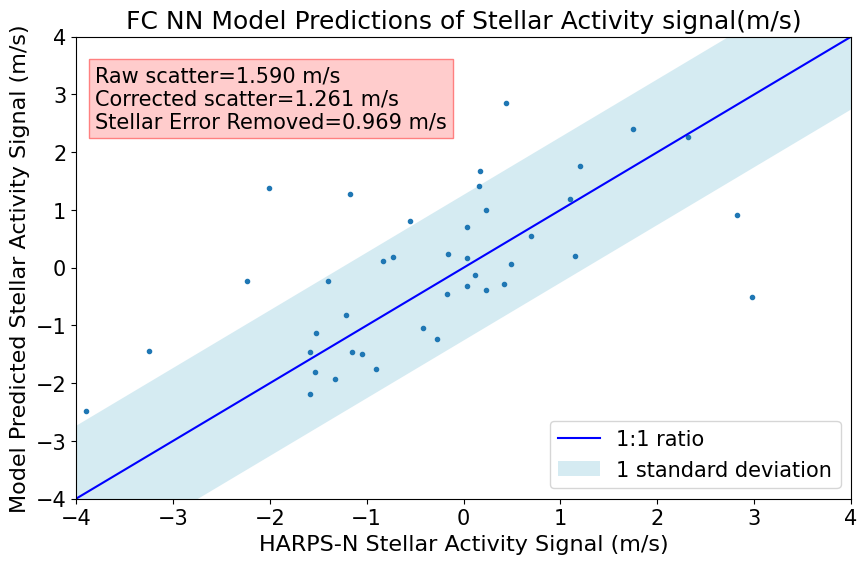

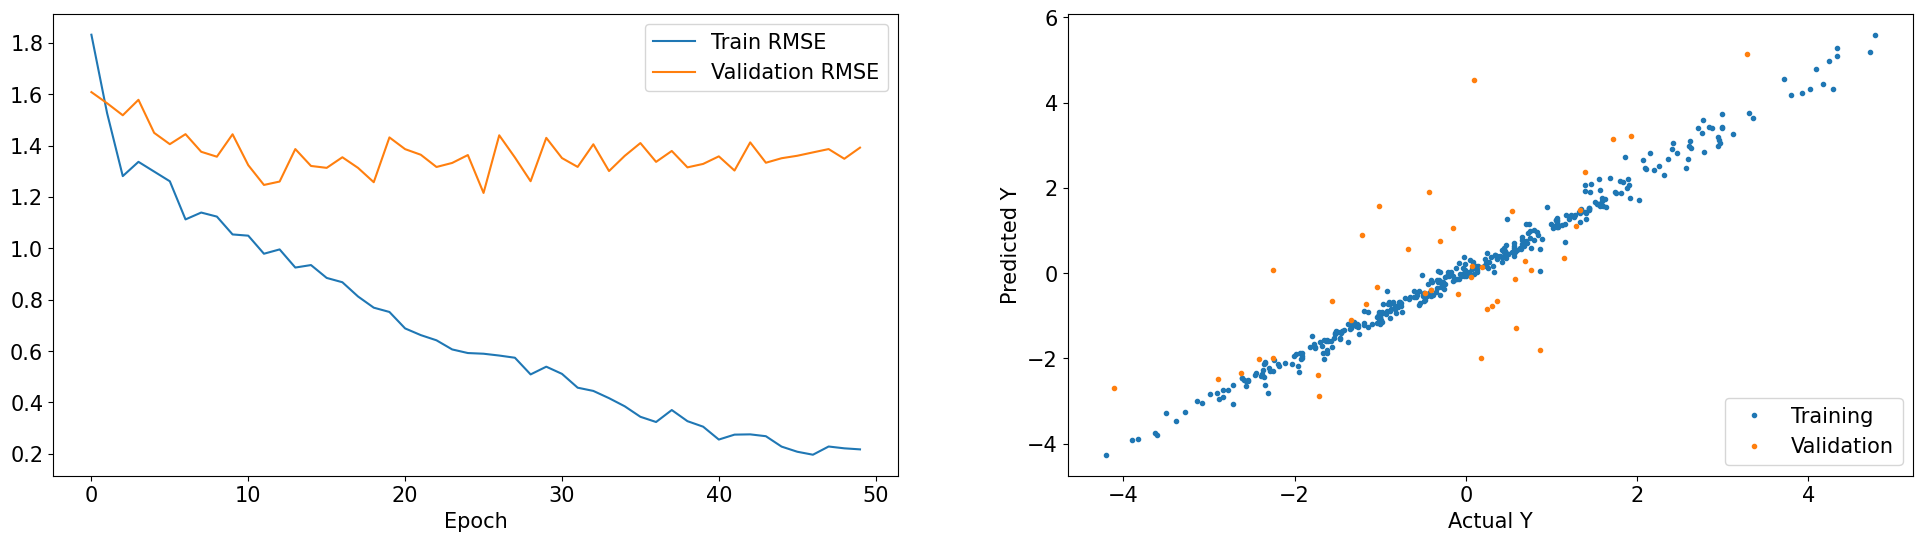

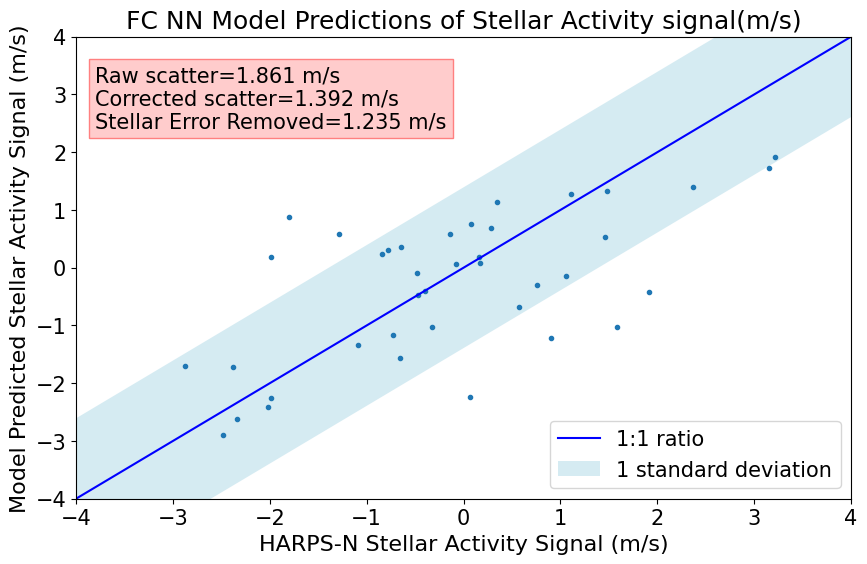

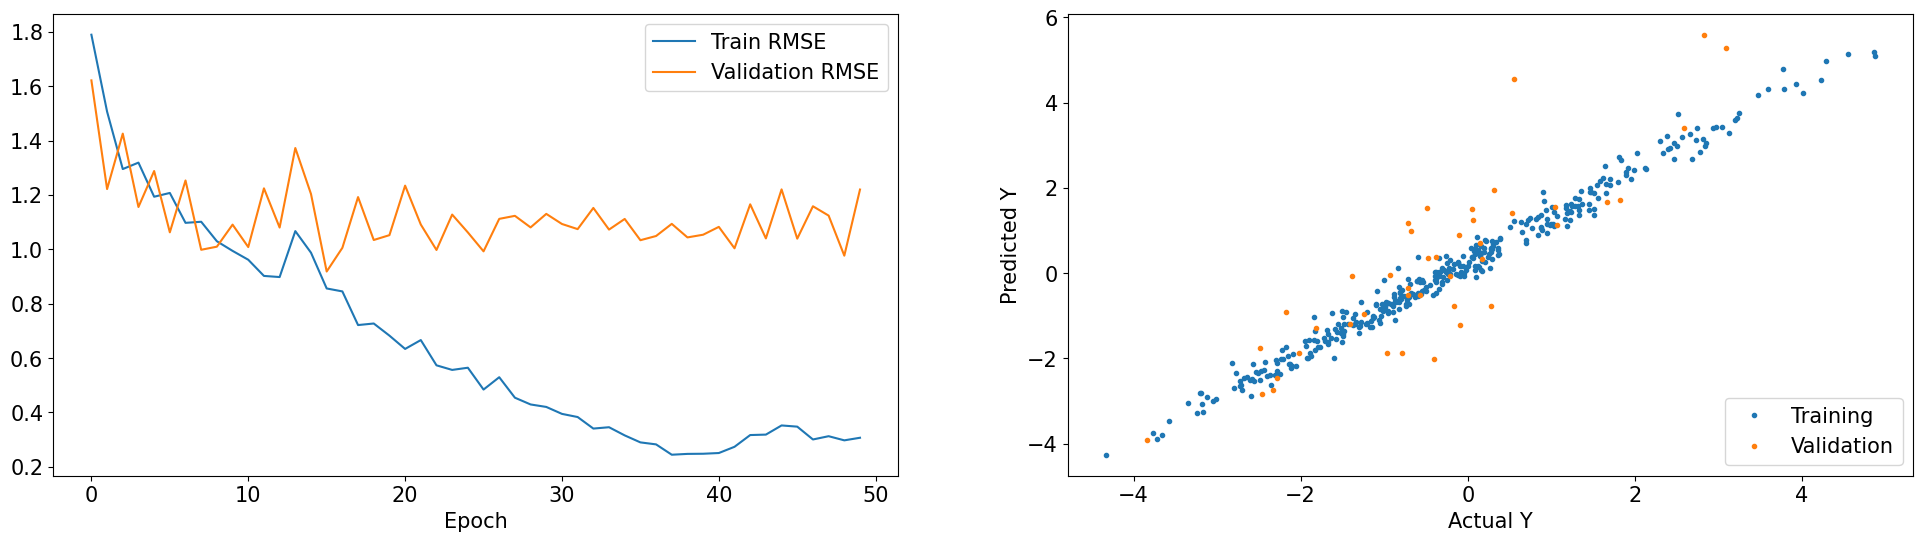

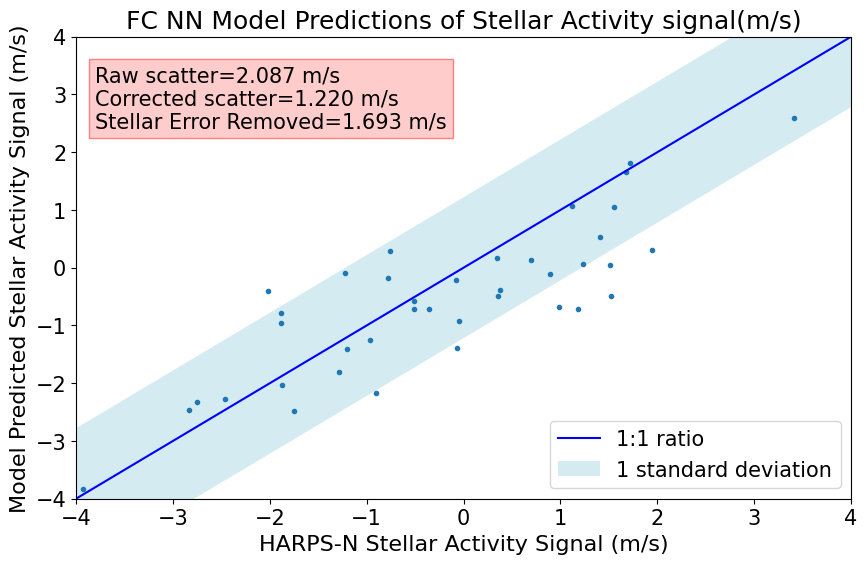

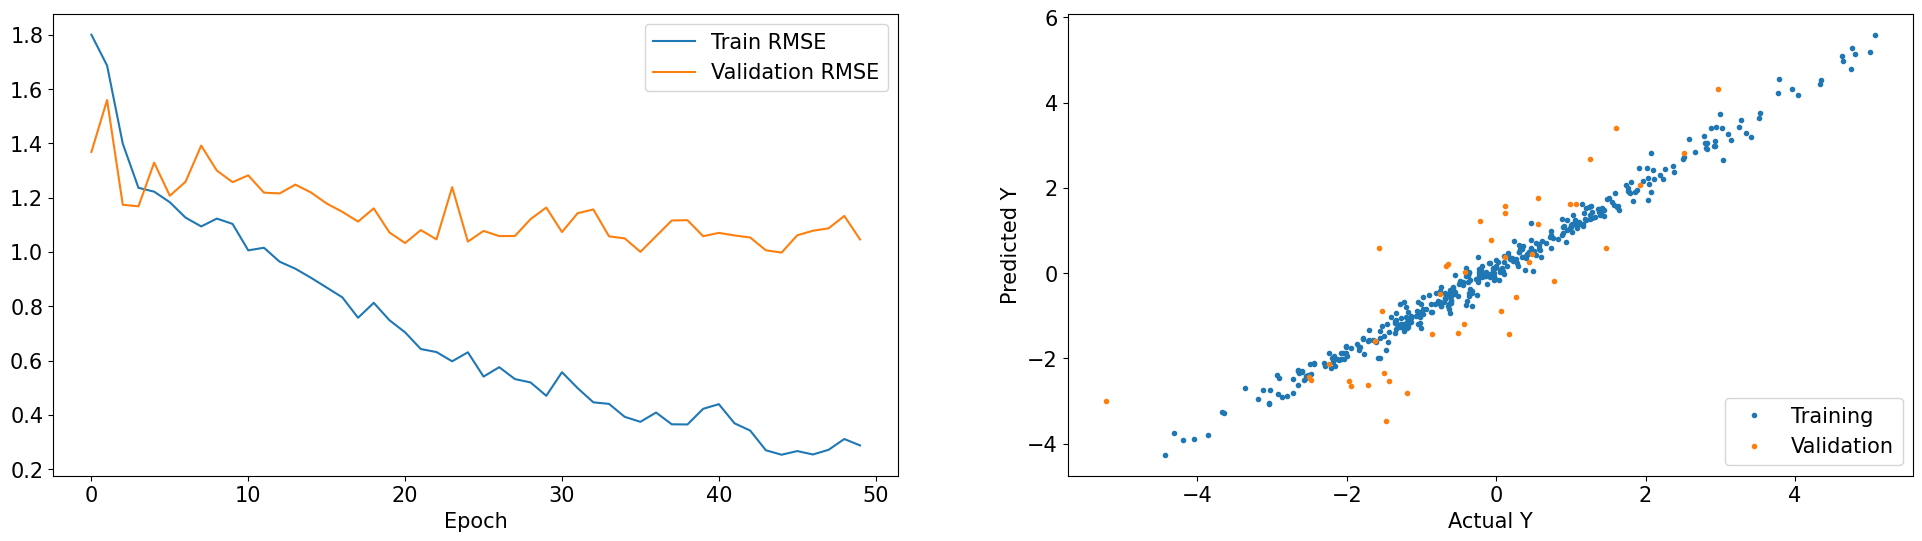

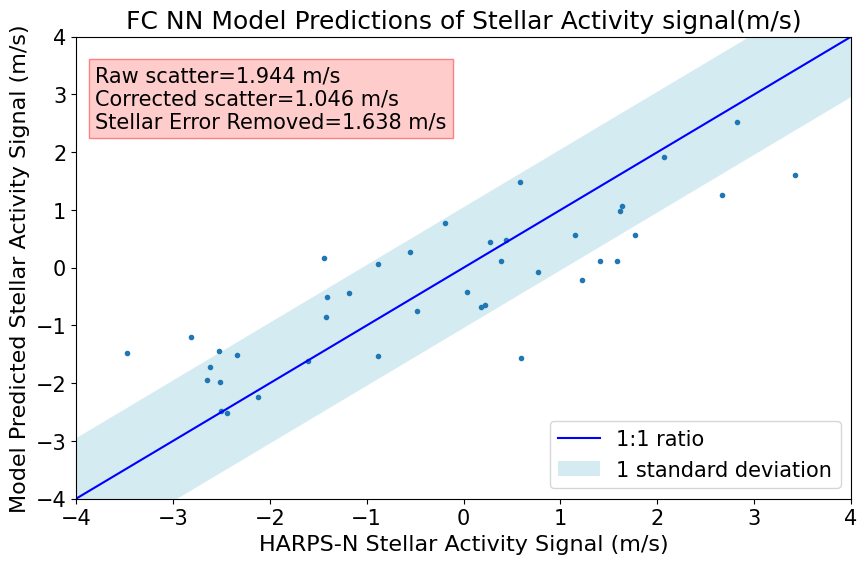

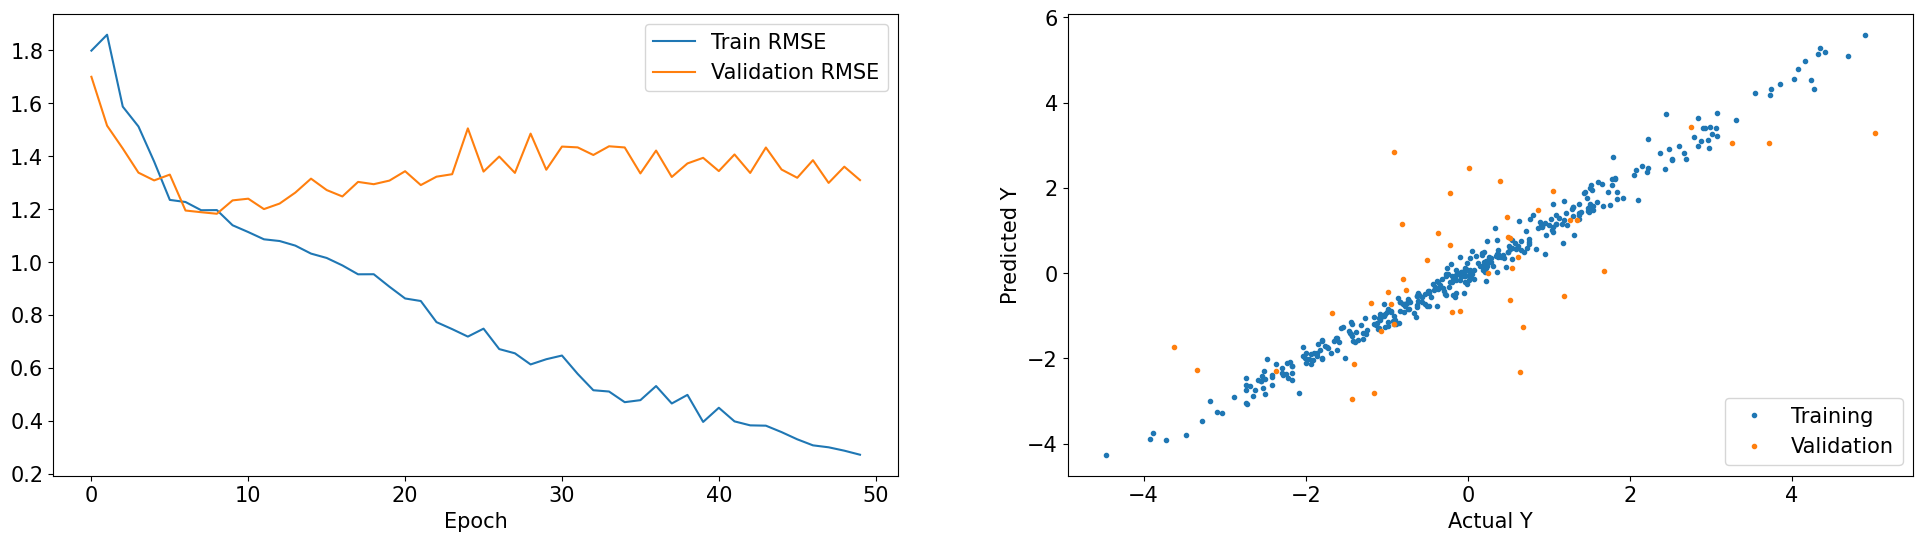

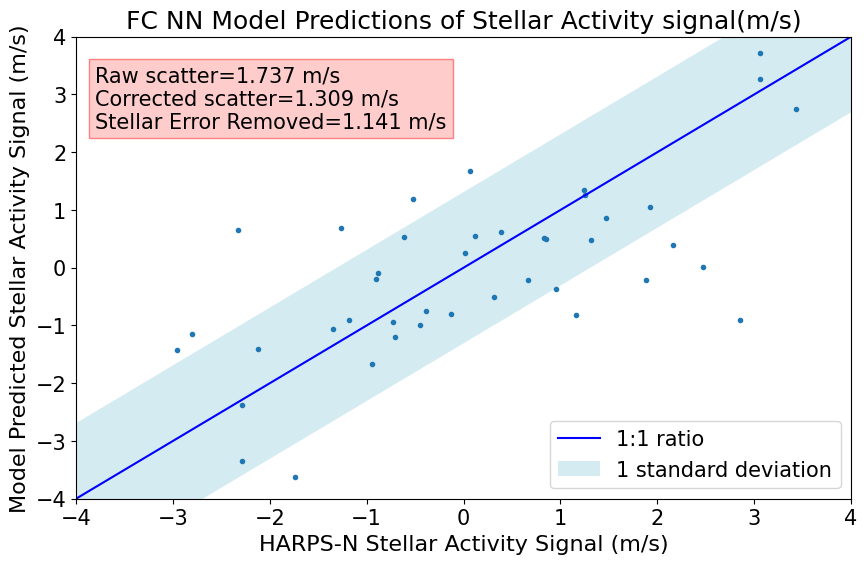

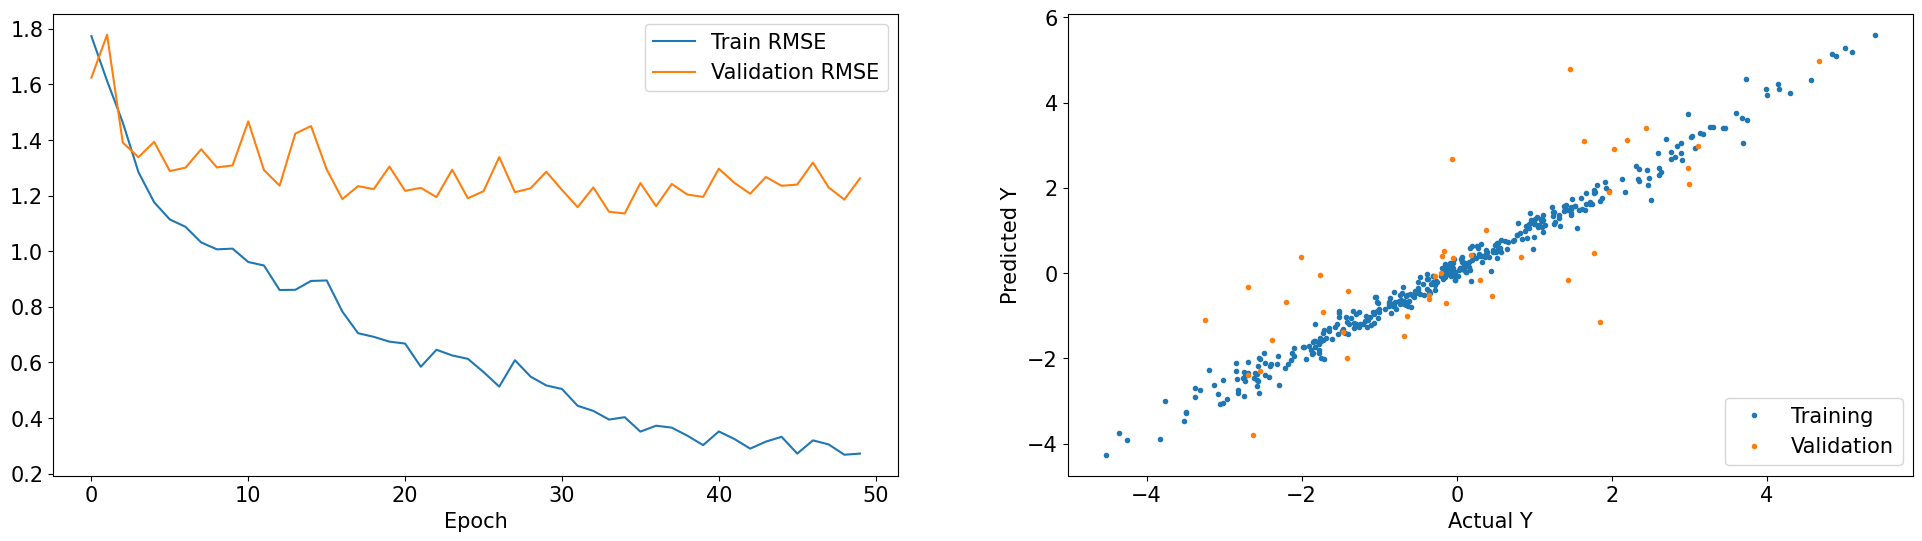

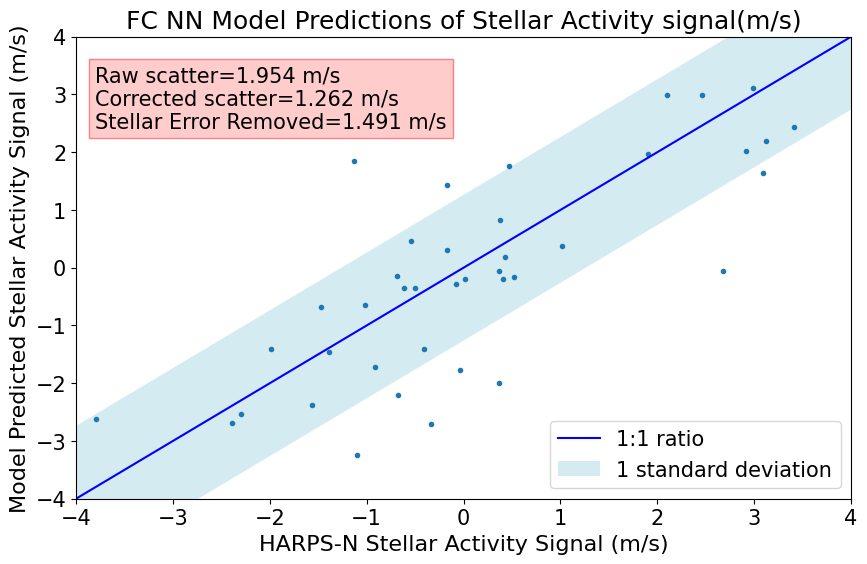

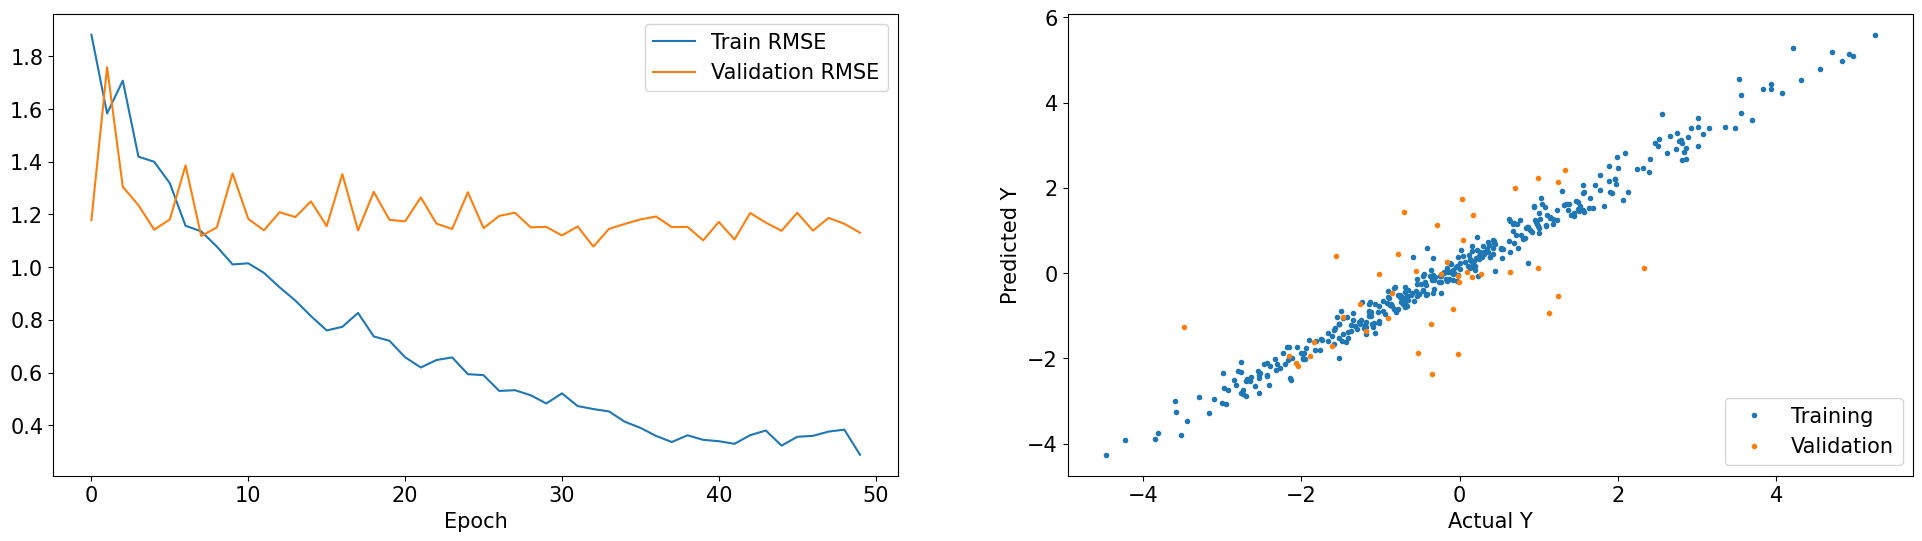

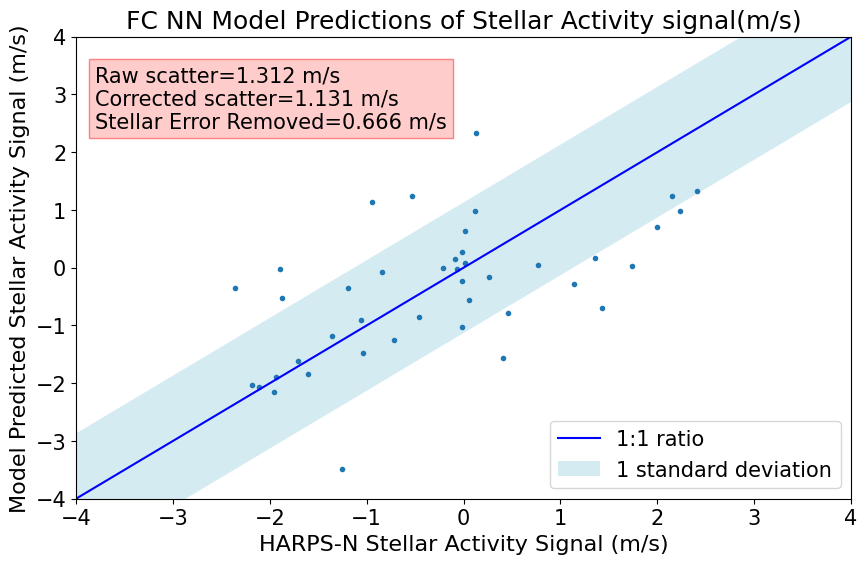

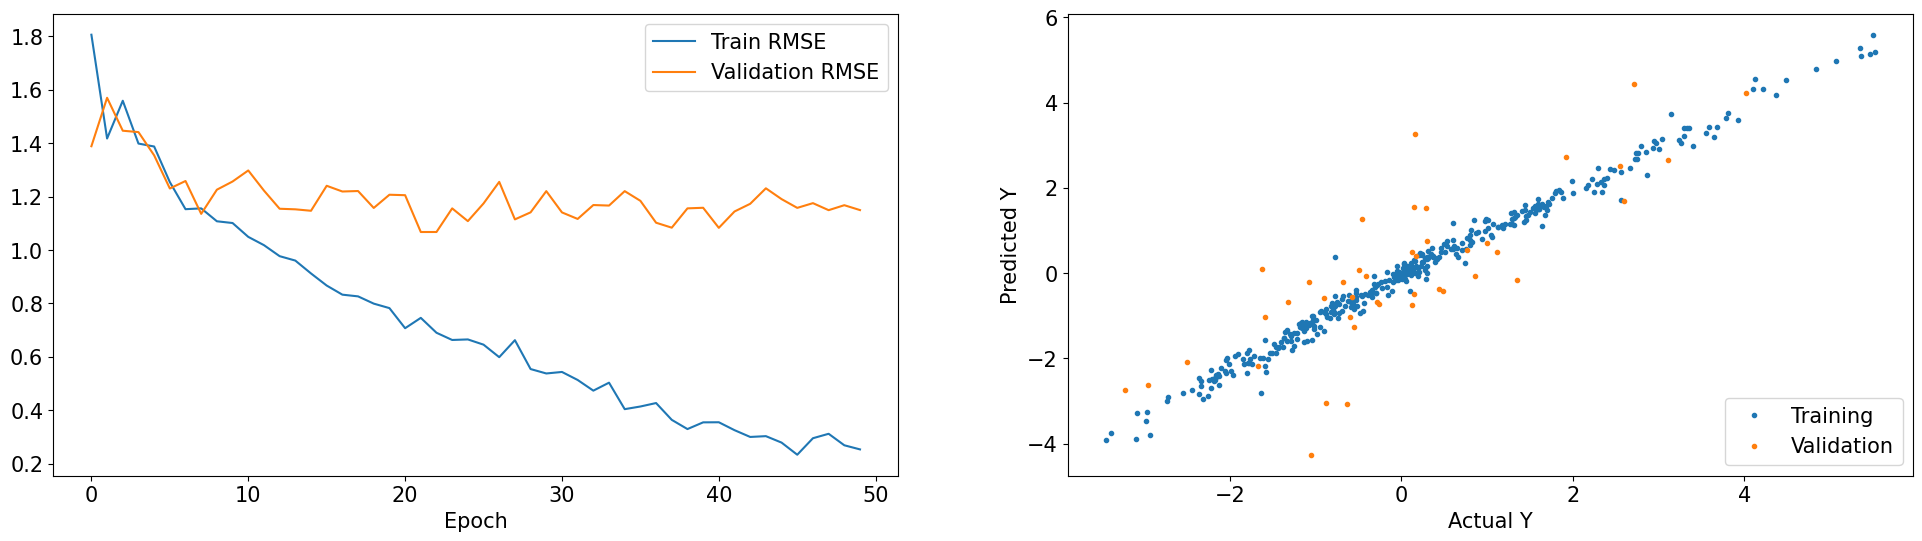

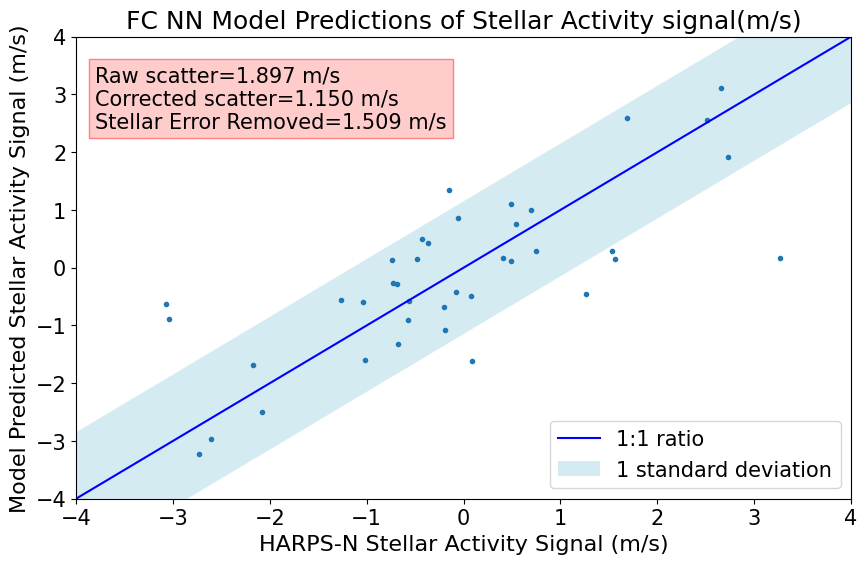

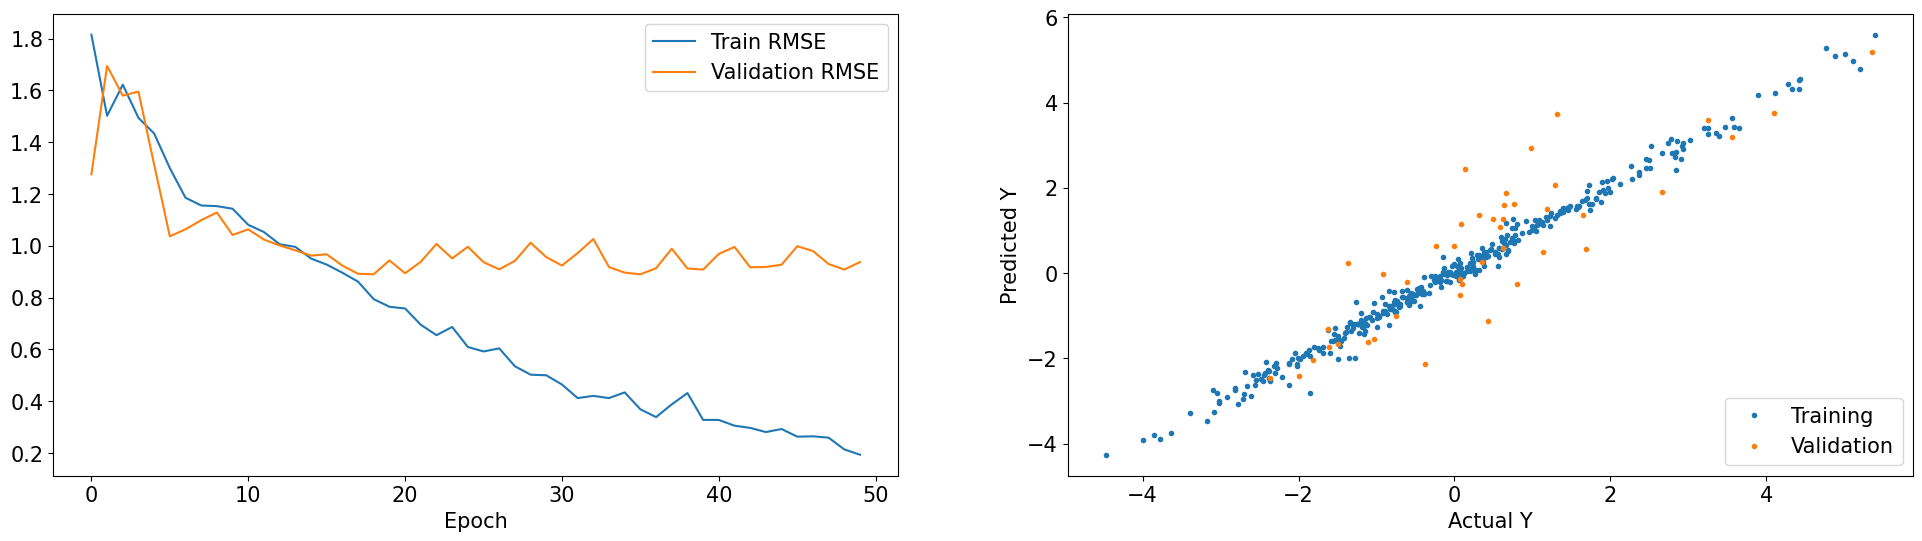

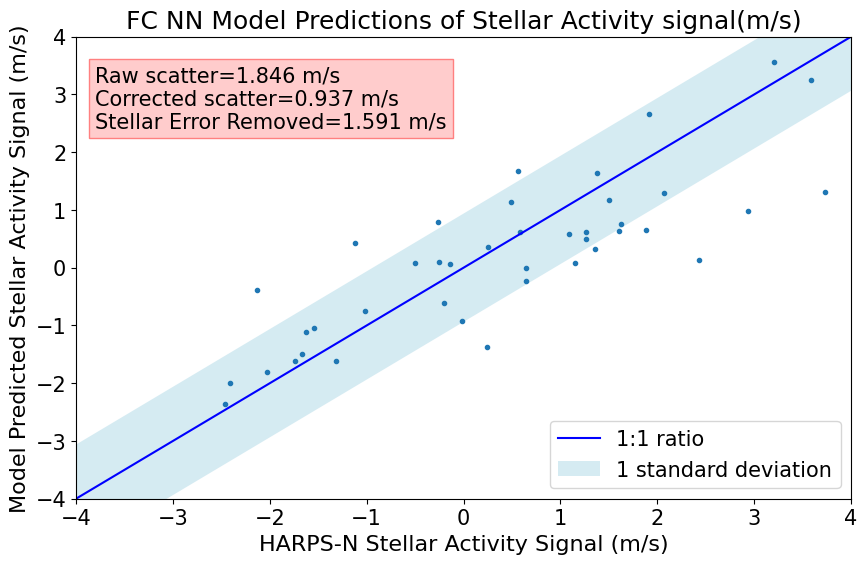

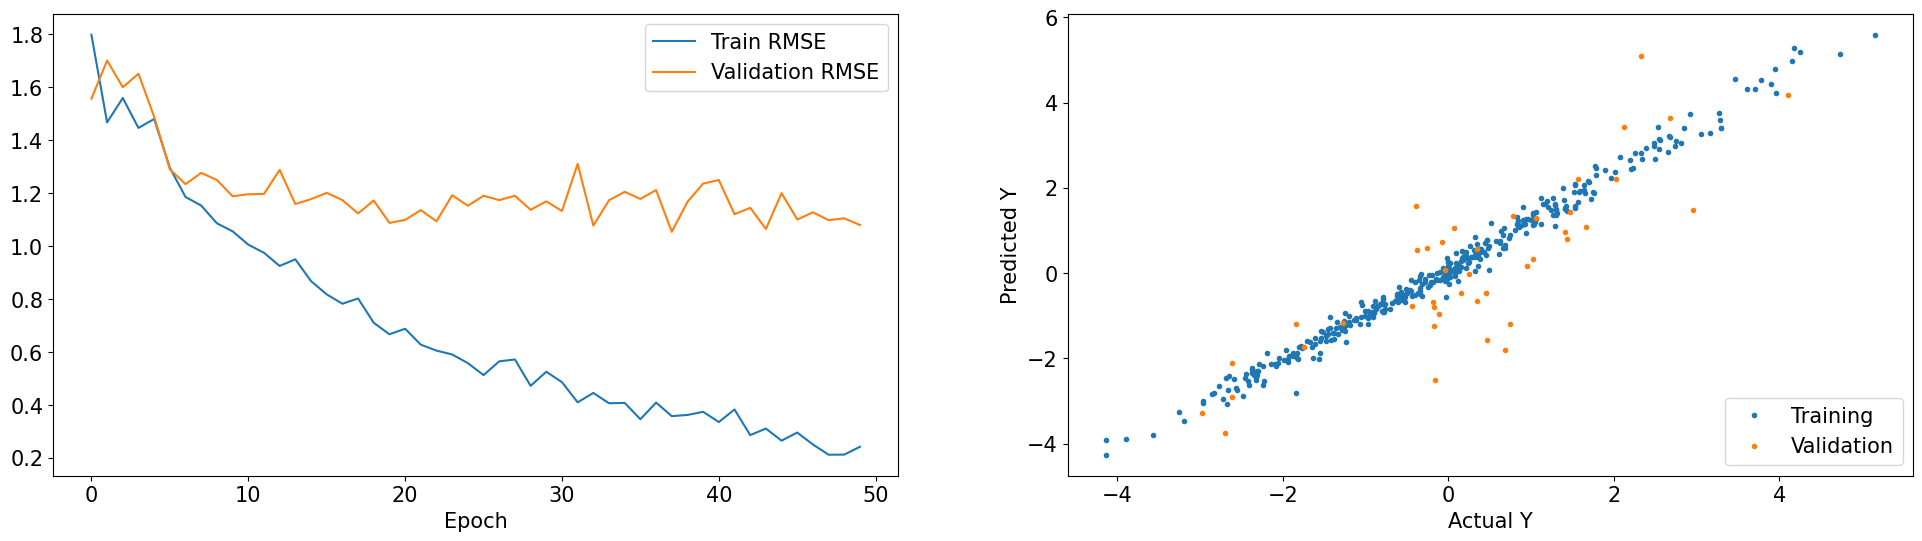

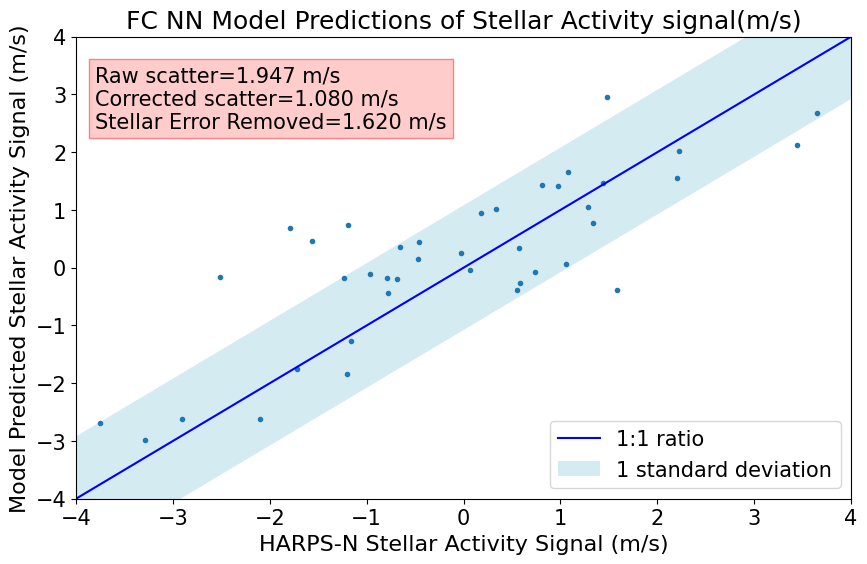

In [26]:
# @title FC NN Model run (Updated)

print("Starting FC NN Model Run...")

# Cross validation Linear NN Model Run (10 times)
rms_avg_list = []
weight_decay_list_t = []
gaussian_noise_list_t = []
rms_x_list = []

all_bjds_val = []
all_pred_val = []
all_labels_val = []
all_mean_val_preds = []
all_mean_val_bjds = []
all_mean_val_labels = []

for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    bjd_run_val = []
    pred_run_val = []
    labels_run_val = []
    all_bjds_val = [] # Re-init for this fold
    
    for k in range(0,1):#0): #should be 10 for a full run
        hparams = SimpleNamespace(**dict(
          num_features=ccf_len, # Use ccf_len variable
          learning_rate=0.0054042, #0.040267, #0.0095352,#0.0016077,
          momentum=0.9, # Not used by AdamW
          batch_size=300,
          num_dense_units=100,#1000,#200,
          num_dense_layers=8, #4,
          weight_decay=0.00010000,#0.008000,#0.00010000, #5e-4, #7e-2,
          gaussian_noise_scale=0,#1.5, 
        ))
        model = FCModel(hparams)
        train(model, hparams, plots="ON",model_name="FC NN", num_epochs=50)
        print(model)
        print("________________________")
        print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
        
    if pred_run_val: # Only calculate mean if list is not empty
        mean_val_preds = np.mean(pred_run_val, axis=0)
        mean_val_labels = np.mean(labels_run_val, axis=0)
        mean_val_bjds = np.mean(bjd_run_val, axis=0)
        all_mean_val_preds.append(mean_val_preds.tolist())
        all_mean_val_labels.append(mean_val_labels.tolist())
        all_mean_val_bjds.append(mean_val_bjds.tolist())
    else:
        print(f"Warning: No predictions recorded for fold {index+1}")

avg = np.mean(rms_avg_list)
print("________________________")
print(f"Final Average RMS: {avg}")

#flatten the lists
all_mean_val_preds_flat = [item for sublist in all_mean_val_preds for item in sublist]
all_mean_val_labels_flat = [item for sublist in all_mean_val_labels for item in sublist]
all_mean_val_bjds_flat = [item for sublist in all_mean_val_bjds for item in sublist]

In [ ]:
if all_mean_val_labels_flat: # Only run if predictions were made
    df = pd.DataFrame(list(zip(all_mean_val_labels_flat,all_mean_val_preds_flat, all_mean_val_bjds_flat)), 
                   columns =['labels', 'preds', 'BJD']) 
    df_sorted = df.sort_values(by=['BJD'])
    #df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_FCNN_06_30_2021.xlsx', index = False)

    # calculation of scatter removed
    from astropy.stats import median_absolute_deviation

    #df_sorted = df_from_excel
    labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
    labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
    preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

    corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
    corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
    corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

    sd_labels = np.std(df_sorted["labels"], ddof=1)
    sd_corrected_rv = np.std(corrected_rvs, ddof=1)
    rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


    print("labels: sd: "+str(sd_labels))
    print("corrected rv: sd: "+str(sd_corrected_rv))
    print("____________________________________________")
    print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
    print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
    print("____________________________________________")
    print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
    print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


    # plot the average results
    # Scatter reduction plot
    rms_avg_list = []
    sd_x = np.std(all_mean_val_labels_flat, ddof=1)
    rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels_flat - np.array(all_mean_val_preds_flat))))
    #rms_x_list.append(rms_x)
    rms_avg_list.append(rms_x)
    stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
    x_range = np.linspace(-4,5.5, 17)
    upper_bound = x_range+rms_x
    lower_bound = x_range-rms_x

    # plot the scatter reduction plot
    fig, ax = plt.subplots(1, 2, figsize=(21, 6))
    ax1 = ax[0]
    ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
    ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
    #ax.plot(x_range,z[0]*x_range+z[1], color="blue")
    rms_fill=rms_x#0.15
    ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                    alpha=0.5, label="1 standard deviation")
    ax1.set_xlim(-4, 5);
    ax1.set_ylim(-4, 5);
    ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
    ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
    ax1.set_title("FC NN Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
    #hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
    textstr = '\n'.join((
        r'Raw scatter=%.3f m/s' % (labels_68_percent_by_2, ),
        r'Corrected scatter=%.3f m/s' % (corrected_rvs_68_percent_by_2, ),
        r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
    ax1.text(-3.8, 3.5, textstr, size=15,
            ha="left", va="top",
            bbox=dict(facecolor='#fdcf44',edgecolor='k',
                      boxstyle="square",
                      #ec=(1., 0.5, 0.5),
                      #fc=(1., 0.8, 0.8),
                      ))
    ax1.legend(loc="lower right")

    # plot predictions over time
    ax2 = ax[1]
    ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
             markersize=10,label="labels")
    ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
             label="preds")
    ax2.set_xlabel("Time (BJD)")
    ax2.set_ylabel("RV (m/s)")
    ax2.legend(loc="lower right")
else:
    print("Skipping FC NN plots because no predictions were generated.")

## CNN Model Run

In [ ]:
# @title CNN Model run (Updated)

print("Starting CNN Model Run...")

# Cross validation CNN Model Run (10 times)
rms_avg_list = []
weight_decay_list_t = []
gaussian_noise_list_t = []
rms_x_list = []

all_bjds_val = []
all_pred_val = []
all_labels_val = []
all_mean_val_preds = []
all_mean_val_bjds = []
all_mean_val_labels = []

for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    bjd_run_val = []
    pred_run_val = []
    labels_run_val = []
    all_bjds_val = [] # Re-init for this fold
    
    for k in range(0,2):#0): #should be 10 for a full run
        hparams = SimpleNamespace(**dict(
            num_features=ccf_len, # Use ccf_len variable
            learning_rate=0.0085099,#0.0050618, #1e-3,
            momentum=0.9, # Not used by AdamW
            batch_size=300,
            conv_kernel_size=3,
            num_conv_filters=16, #32,
            num_conv_layers=2,#4,
            num_dense_units=100,#500,
            num_dense_layers=1,
            weight_decay=0.0017600,#0.0012341, #5e-4, #7e-2,
            gaussian_noise_scale=0,#1.5,
        ))
        model = CNNModel(hparams)
        train(model, hparams, plots="OFF",model_name="CNN", num_epochs=90)#35)#65)
        print(model)
        print("________________________")
        print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
        
    if pred_run_val: # Only calculate mean if list is not empty
        mean_val_preds = np.mean(pred_run_val, axis=0)
        mean_val_labels = np.mean(labels_run_val, axis=0)
        mean_val_bjds = np.mean(bjd_run_val, axis=0)
        all_mean_val_preds.append(mean_val_preds.tolist())
        all_mean_val_labels.append(mean_val_labels.tolist())
        all_mean_val_bjds.append(mean_val_bjds.tolist())
    else:
        print(f"Warning: No predictions recorded for fold {index+1}")

avg = np.mean(rms_avg_list)
print("________________________")
print(f"Final Average RMS: {avg}")

#flatten the lists
all_mean_val_preds_flat = [item for sublist in all_mean_val_preds for item in sublist]
all_mean_val_labels_flat = [item for sublist in all_mean_val_labels for item in sublist]
all_mean_val_bjds_flat = [item for sublist in all_mean_val_bjds for item in sublist]

In [ ]:
if all_mean_val_labels_flat: # Only run if predictions were made
    df = pd.DataFrame(list(zip(all_mean_val_labels_flat, all_mean_val_preds_flat, all_mean_val_bjds_flat)), 
                   columns =['labels', 'preds', 'BJD']) 
    df_sorted = df.sort_values(by=['BJD'])
    #df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_CNN_06_30_2021.xlsx', index = False)

    # calculation of scatter removed
    from astropy.stats import median_absolute_deviation

    #df_sorted = df_from_excel
    labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
    labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
    preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

    corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
    corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
    corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

    sd_labels = np.std(df_sorted["labels"], ddof=1)
    sd_corrected_rv = np.std(corrected_rvs, ddof=1)
    rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


    print("labels: sd: "+str(sd_labels))
    print("corrected rv: sd: "+str(sd_corrected_rv))
    print("____________________________________________")
    print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
    print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
    print("____________________________________________")
    print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
    print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


    # plot the average results
    # Scatter reduction plot
    rms_avg_list = []
    sd_x = np.std(all_mean_val_labels_flat, ddof=1)
    rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels_flat - np.array(all_mean_val_preds_flat))))
    #rms_x_list.append(rms_x)
    rms_avg_list.append(rms_x)
    stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
    x_range = np.linspace(-4,5.5, 17)
    upper_bound = x_range+rms_x
    lower_bound = x_range-rms_x

    # plot the scatter reduction plot
    fig, ax = plt.subplots(1, 2, figsize=(21, 6))
    ax1 = ax[0]
    ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
    ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
    #ax.plot(x_range,z[0]*x_range+z[1], color="blue")
    rms_fill=rms_x#0.15
    ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                    alpha=0.5, label="1 standard deviation")
    ax1.set_xlim(-4, 5);
    ax1.set_ylim(-4, 5);
    ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
    ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
    ax1.set_title("CNN Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
    #hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
    textstr = '\n'.join((
        r'Raw scatter=%.3f m/s' % (labels_68_percent_by_2, ),
        r'Corrected scatter=%.3f m/s' % (corrected_rvs_68_percent_by_2, ),
        r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
    ax1.text(-3.8, 3.5, textstr, size=15,
            ha="left", va="top",
            bbox=dict(facecolor='#fdcf44',edgecolor='k',
                      boxstyle="square",
                      #ec=(1., 0.5, 0.5),
                      #fc=(1., 0.8, 0.8),
                      ))
    ax1.legend(loc="lower right")

    # plot predictions over time
    ax2 = ax[1]
    ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
             markersize=10,label="labels")
    ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
             label="preds")
    ax2.set_xlabel("Time (BJD)")
    ax2.set_ylabel("RV (m/s)")
    ax2.legend(loc="lower right")
else:
    print("Skipping CNN plots because no predictions were generated.")